In [1]:
import numpy as np
import time
import random
import math
import matplotlib.pyplot as plt

# The Ising Model
first, initialize the grid

In [2]:
def setup_ini_state(size_):
    """setup the initial grid (ini_state) and a grid (pd_state) that contains
    periodic boundary conditions by extending the initial grid.
    
    
    args:
        size_ (list-like): size of the grid
    
    returns:
        ini_state (np.ndarray): initial state 
        pd_state (np.ndarray): staet with periodic boundary condition
        """
    
    #initialize the grid with random integers 1 and 0
    ini_state=np.random.randint(2,size=size_)
    #replce 0 with -1
    ini_state[ini_state==0]=-1
    
    
    #make pd_state with size +2/ +2 for row and column respectively
    pd_state=np.zeros([size_[0]+2,size_[1]+2])
    
    #boundary will be alternationg (-1)^n
    row_alt=np.array([int((-1)**t) for t in range(0,size_[1])])
    col_alt=np.array([int((-1)**t) for t in range(0,size_[0])])
    
    #copy and paste the alternating array to the pd_state
    pd_state[0,1:-1]=row_alt[:]
    pd_state[-1,1:-1]=row_alt[:]
    pd_state[1:-1,0]=col_alt[:]
    pd_state[1:-1,-1]=col_alt[:]
    
    #then copy and paste the ini_state onto the pd_state
    pd_state[1:-1,1:-1]=ini_state[:,:]
    
    return ini_state,pd_state

state,pd_state=setup_ini_state([51,49])

print("Dimension of the initial state: ")
print(state.shape)
print("Dimension of the wrap state: ")
print(pd_state.shape)

Dimension of the initial state: 
(51, 49)
Dimension of the wrap state: 
(53, 51)


Want to make spure ini_state is a sub_array of wrap_ini_state in its middle components

In [3]:
assert np.all(pd_state[1:-1,1:-1]==state)

This ising model is done by only considering the nearest neighbors (no diagonal). that is , the Perturbation Hamiltonian H to the middle spin is

In the ising model notebook, given the Hamiltonian for the ising model,

$$ H(S_1,\ldots,S_N) = -J \sum_{i,j} S_i S_j - B \sum_k S_k $$
 it recommends saving the expensive exponential term
 
$$ r = \frac{p_f}{p_i} = e^{(E_f-Ei)/kT} $$
onto an list-like object, but I don't think the exponent term is expensive at all since we are using numpy. Suppose we are forced to compute the exponent term for all points in 51*41 grid, and we do 2000 iterations. Then:


In [4]:

begin=time.time()

for i in range(51*49*2000):
    np.exp(-np.random.randint(1,10+1))
    
end=time.time()
print("time required")
print(end-begin)

time required
12.415877342224121


which is barely noticeable (especially we are including the np.random) in the actual iteraion process which are iterated at  $n<2000$, so the little benefit in efficiency doesn't really outweigh the disadvantage of making the problem of confusing to code.

In [5]:
def Ising_evolution(state,pd_state,B,T,J):
    """evolves the grid with spins according to the metropolis algorithm
    state(np.ndarray) : state of the grid
    pd_state(np.ndarray) : extended state with periodic boundary (-1)**n.
    
    args:
        B(float) : perturbation field 
        T (float) : temperature
        J(float): spin coupling constant
    returns:
        return_state (np.ndarray): state to be returned (modified state)
        pd_state (np.ndarray): pd_state must be returned so that the next 
                                iteration changes the parity of boundary spins.
    """
    
    #returning state copy
    return_state=state.copy()
    
    #change the parity of the boundary spins
    pd_state[0,:]=-pd_state[0,:]
    pd_state[-1,:]=-pd_state[-1,:]
    pd_state[:,0]=-pd_state[:,0]
    pd_state[:,-1]=-pd_state[:,-1]
    
    
    for x in np.arange(state.shape[0]):
        for y in np.arange(state.shape[1]):

            S_k=state[x,y] #middle spin
            S_k_other=-S_k #middle spin after flip
            
            #note each x and y must be translated right/down to share the
            #coordinate with the pd_state
            
            #get spins for row neighbors
            S_x1=pd_state[x+1+1,y+1]
            S_x_1=pd_state[x-1+1,y+1]
            #get spins for column neighbors
            S_y1=pd_state[x+1,y+1+1]
            S_y_1=pd_state[x+1,y-1+1]
            
            #energy of current spin
            f=S_x1+S_x_1+S_y1+S_y_1
            H_k_current=-J*S_k*f-B*S_k
            #energy of flipped spin
            H_k_other=-J*S_k_other*f-B*S_k_other
            
            #change in energy
            dE=H_k_other-H_k_current

            #always acc
            if dE<0:
                return_state[x,y]=S_k_other
            elif dE>0:
                P=min(1,np.exp(-dE/T))
                return_state[x,y]=np.random.choice([S_k_other,S_k],p=[P,1-P])
    return return_state,pd_state

### Magnetization function

In [6]:
def magnetization(state,norm=False):
    """calculates the magnetization of the grid
    
    args:
        norm(bool): normalize the magnetization per spin
        state(np.ndarray): input grid
        
    returns:
        magnetization (float): norm or non-norm versions"""
    
    #shape, tot number of spins
    x,y=state.shape
    leng=x*y
    
    #count # of up state
    TF1=state==1
    count=np.where(TF1)
    up_count=count[0].shape[0]
    
    down_count=leng-up_count
    
    
    mag=up_count-down_count
    
    if norm:
        return mag/leng
    elif not norm:
        return mag

### Case 1: $J=(k_B T)$, $B=[0,0.5,-0.5]$

Throughout the notebook, we convenient adopt the natural unit system, so $k_B=1$

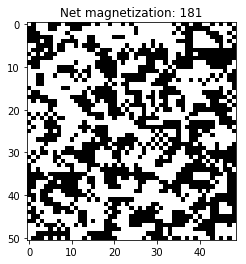

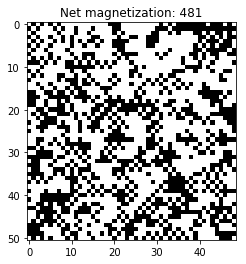

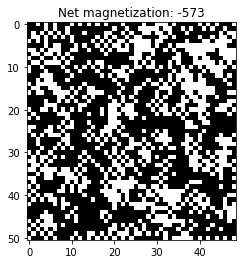

In [7]:
B=[0,0.5,-0.5]
T=1
J=T
#-1 = black
# 1 = white

for b in B:
    state,pd_state=setup_ini_state([51,49])
    for i in range(200):
        state,pd_state=Ising_evolution(state,pd_state,b,T,J)
    plt.title("Net magnetization: "+str(magnetization(state)))
    plt.imshow(state,cmap='gray')
    plt.show()

### Case2:  $B=0,\frac{J}{Tk_B}$ = range(0.0,21,0.6)

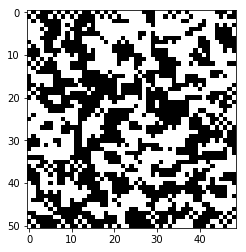

In [24]:
B=0
T=1
J=[i*0.6/T for i in range(1,int(11//0.6)+1)]
mag_list=[]

for j in [8]:
    state,pd_state=setup_ini_state([51,49])
    for i in range(2400):
        state,pd_state=Ising_evolution(state,pd_state,B,T,j)
    
    
    mag_list.append(magnetization(state,norm=True))
    
    plt.imshow(state,cmap='gray')
    plt.show()

In [ ]:
np.array(mag_list)

In [ ]:
plt.plot(J,np.abs(np.array(mag_list)))
plt.show()

# Hysteresis

A phenomena where the output magnetization lag behind the input change in magnetic field. We want to change the perturbation field fast enough so that this lagging behind is clearly observed.

In [119]:
mag_list=[]
B1=[]
B2=[]
B0=[]
T=2
J=1

B=np.linspace(0,8,12)
state,pd_state=setup_ini_state([51,49])

for b in B:
    for i in range(1):
        state,pd_state=Ising_evolution(state,pd_state,b,T,J)
    B0.append(magnetization(state))

B=np.linspace(-8,8,12)

for b in B:
    for i in range(1):
        state,pd_state=Ising_evolution(state,pd_state,b,T,J)
    B1.append(magnetization(state))

B=np.linspace(8,-8,12)

for b in B:
    for i in range(1):
        state,pd_state=Ising_evolution(state,pd_state,b,T,J)
    B2.append(magnetization(state))

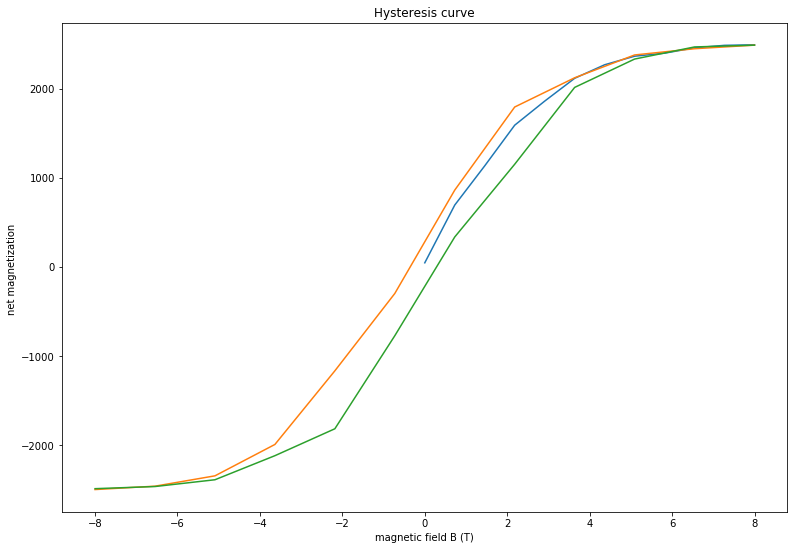

In [124]:
plt.figure(figsize=[13,9])

plt.title("Hysteresis curve")
plt.plot(np.linspace(0,8,12),B0)
plt.plot(np.linspace(-8,8,12),B1)
plt.plot(np.linspace(8,-8,12),B2)

plt.ylabel("net magnetization ")
plt.xlabel("magnetic field B (T)")
plt.show()

## Anti-ferromagnetic

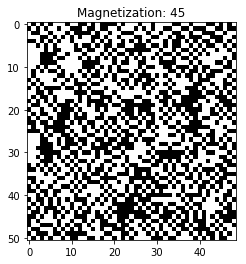

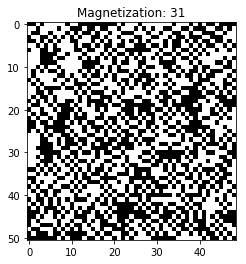

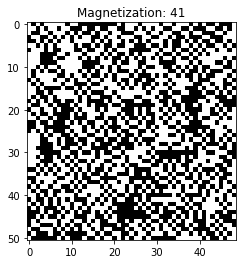

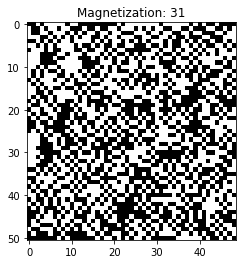

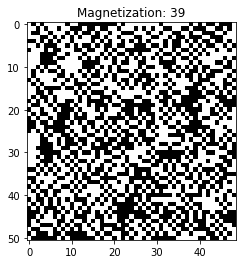

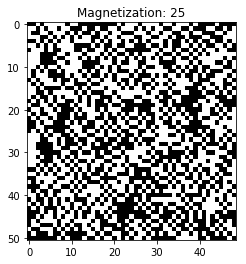

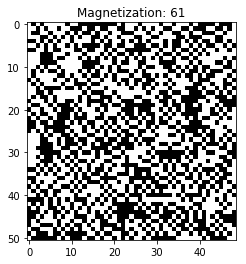

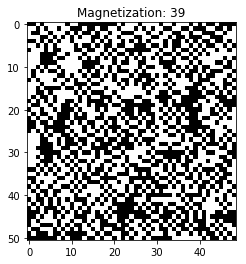

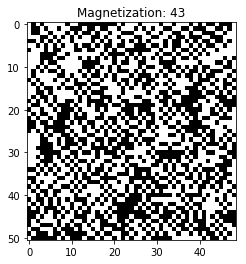

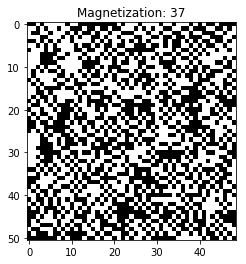

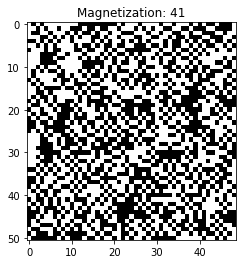

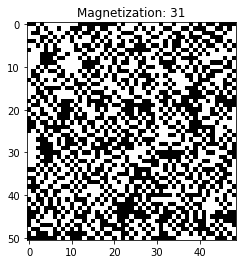

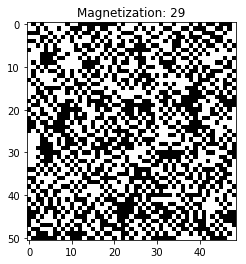

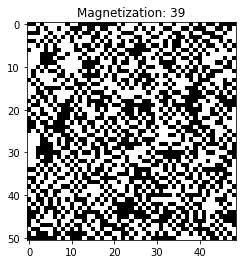

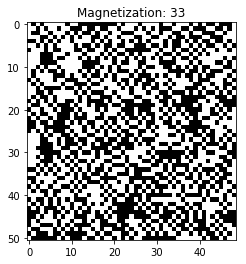

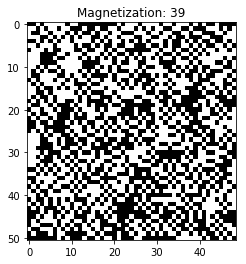

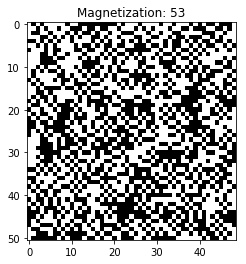

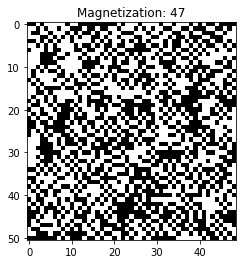

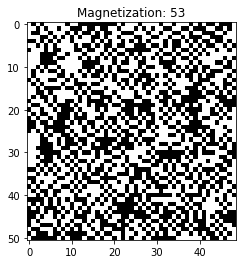

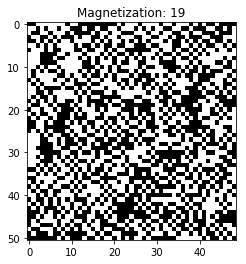

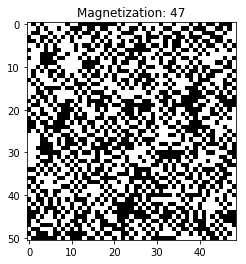

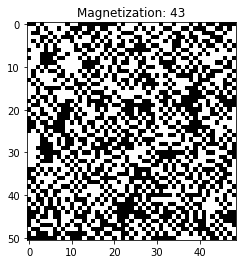

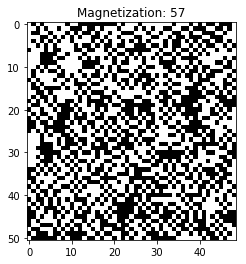

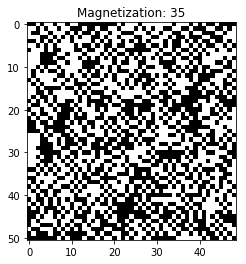

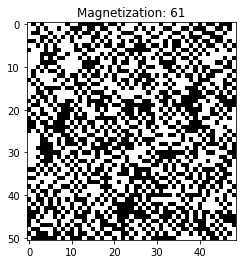

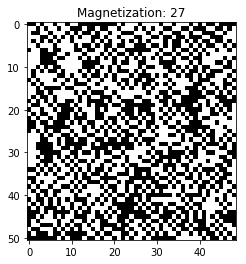

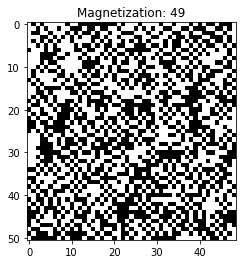

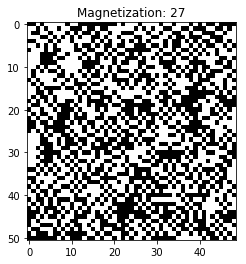

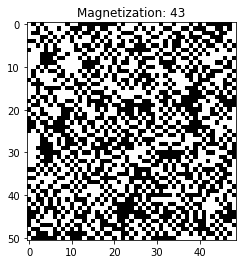

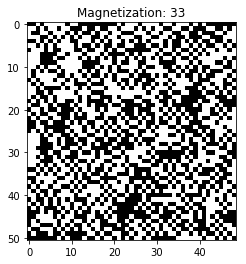

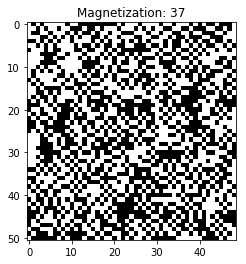

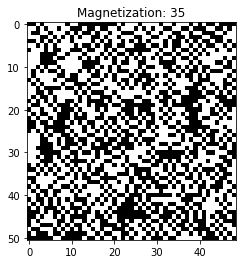

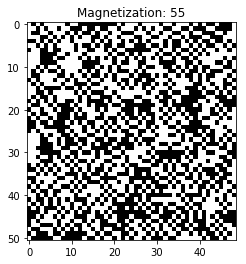

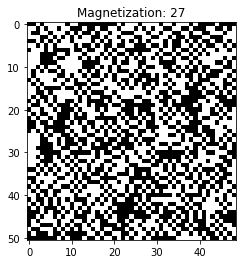

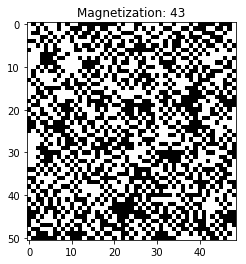

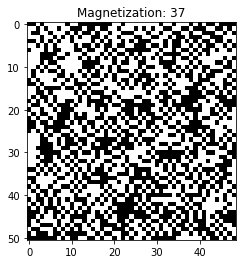

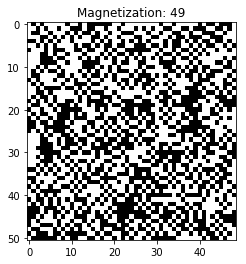

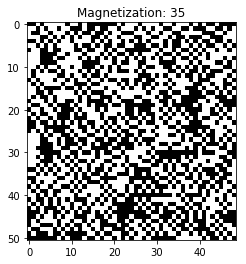

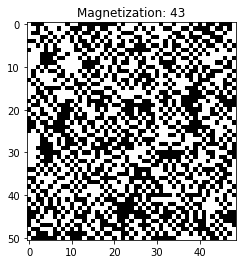

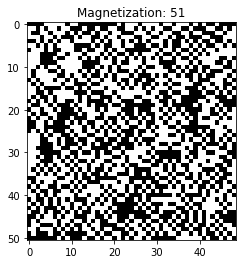

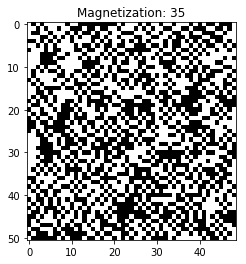

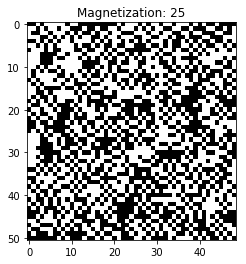

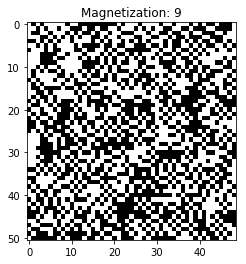

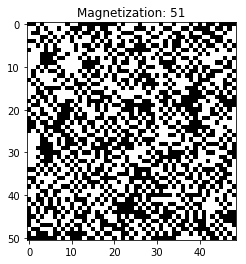

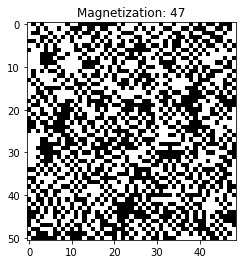

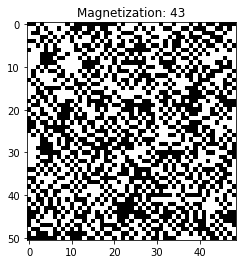

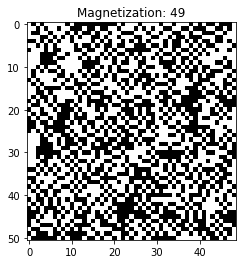

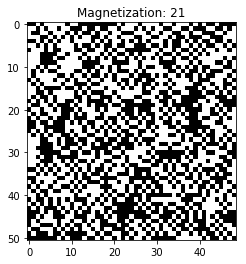

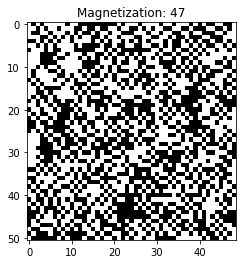

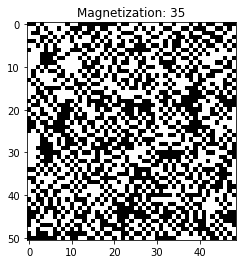

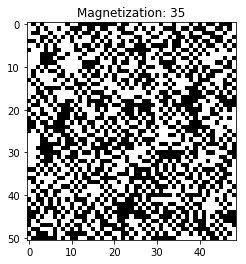

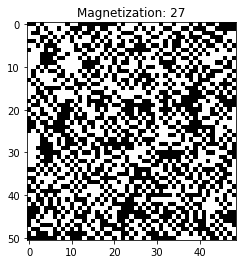

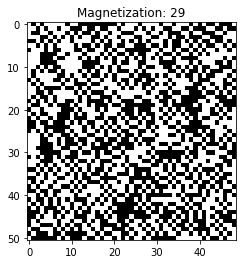

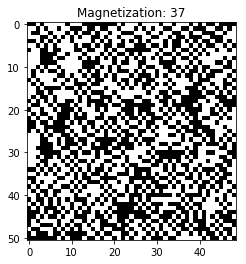

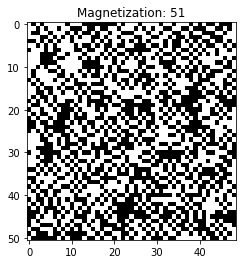

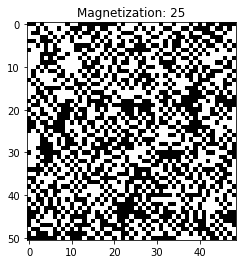

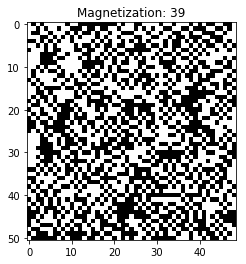

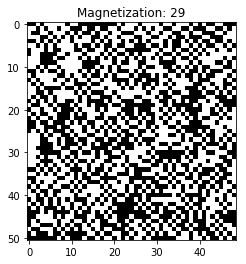

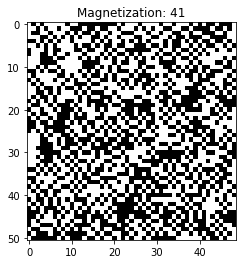

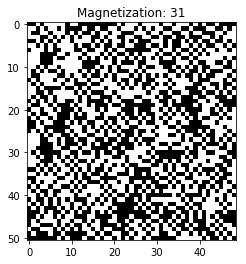

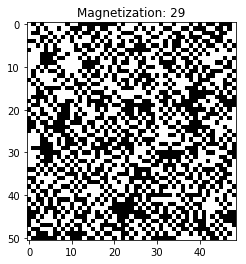

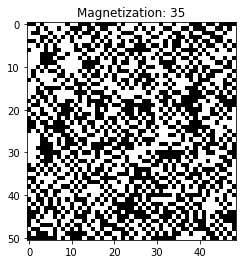

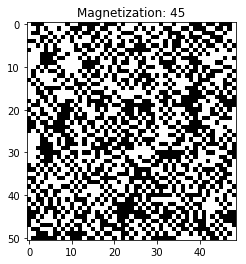

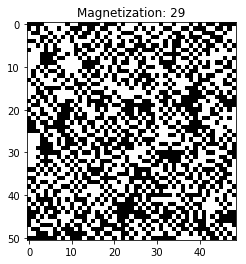

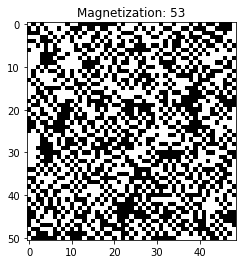

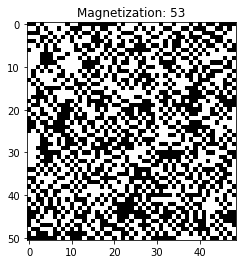

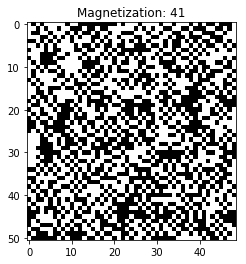

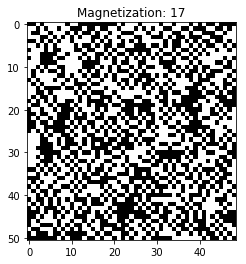

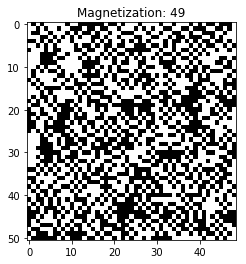

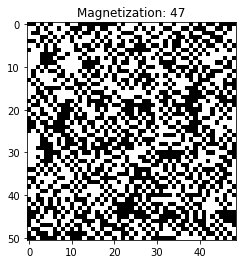

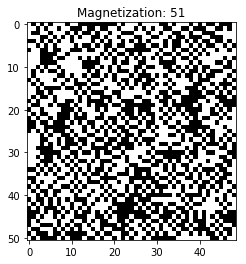

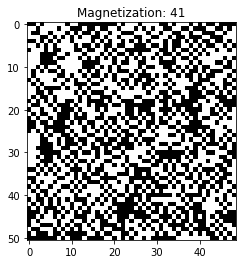

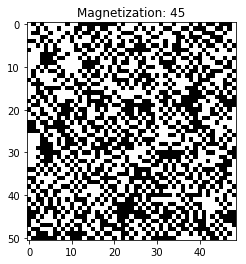

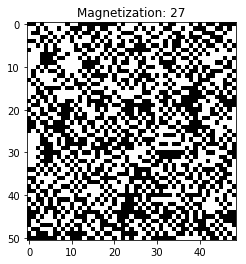

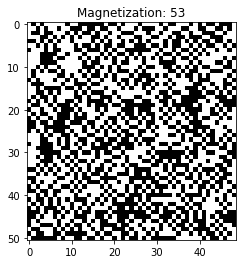

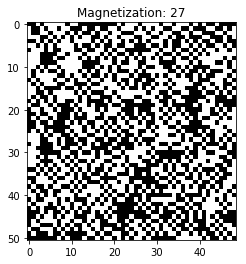

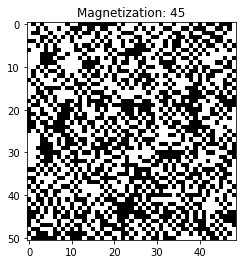

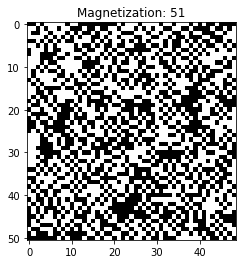

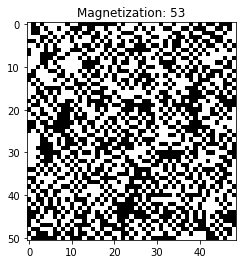

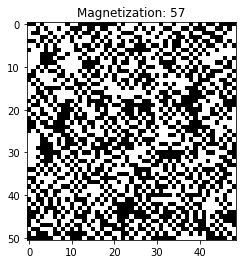

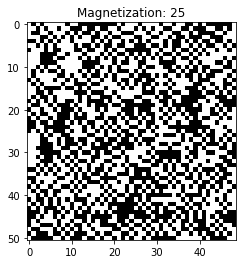

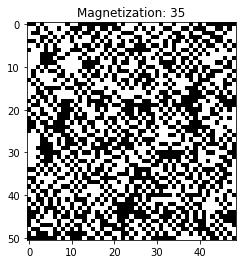

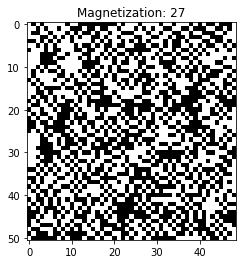

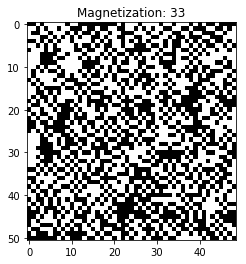

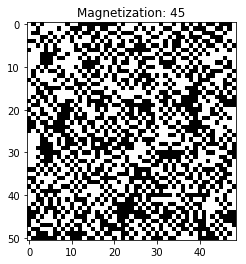

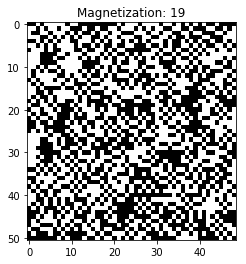

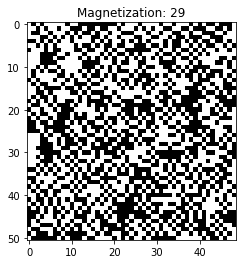

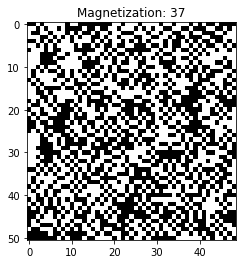

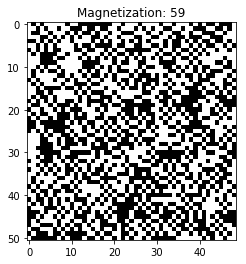

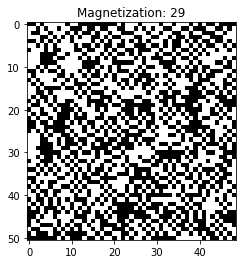

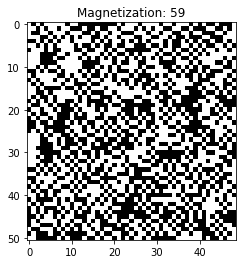

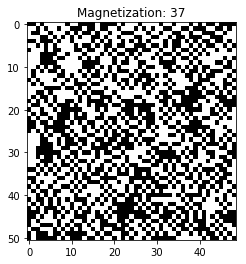

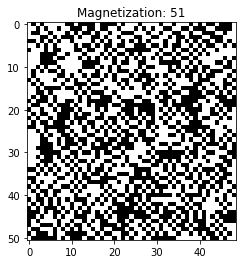

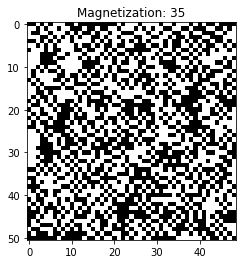

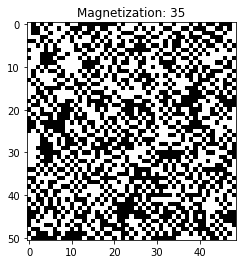

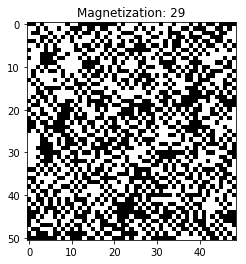

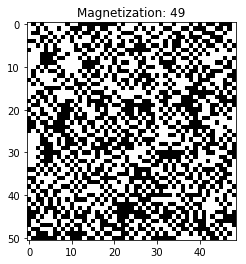

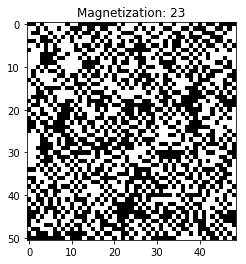

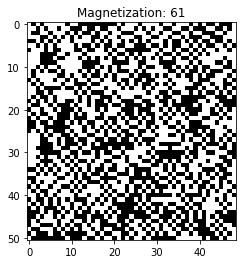

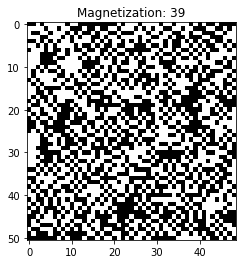

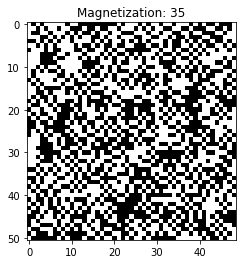

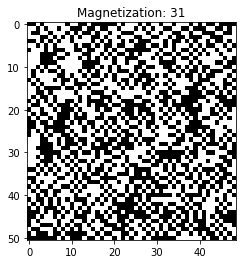

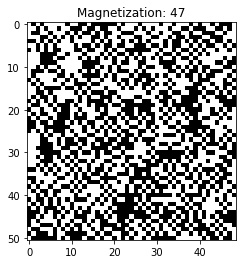

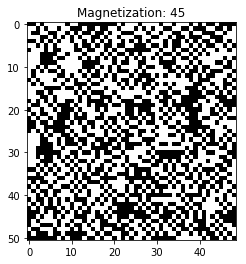

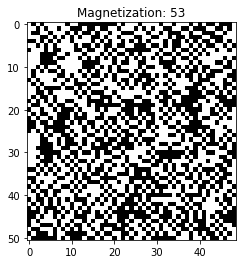

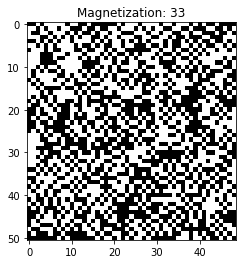

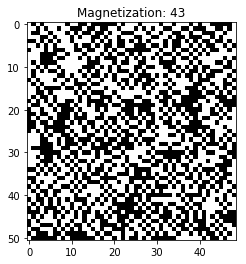

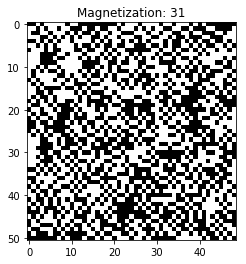

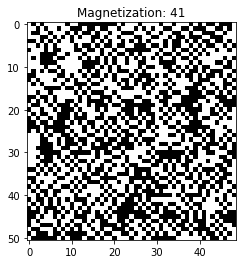

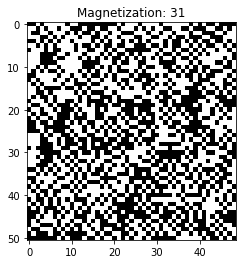

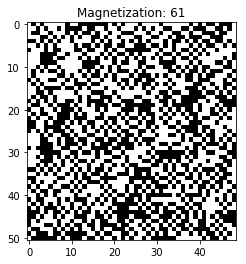

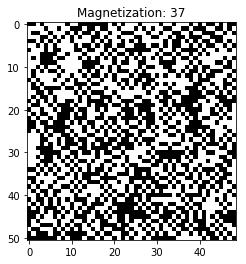

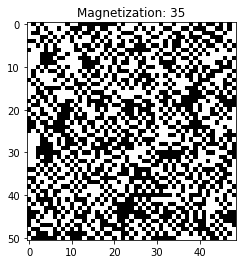

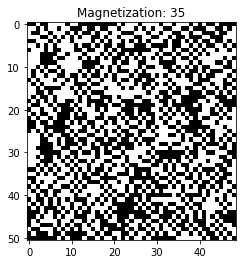

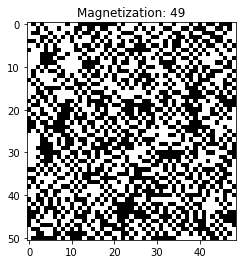

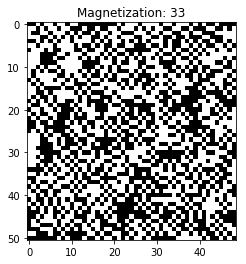

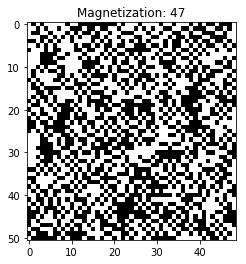

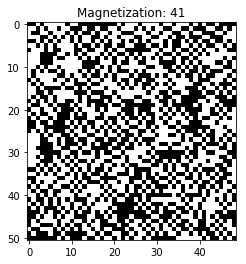

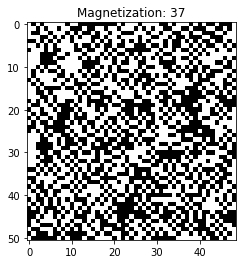

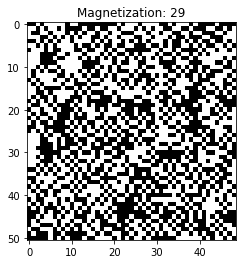

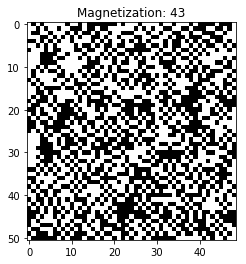

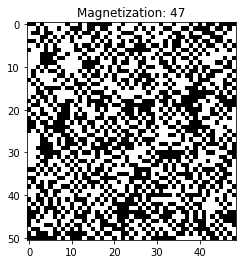

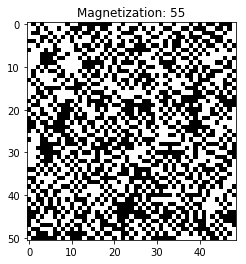

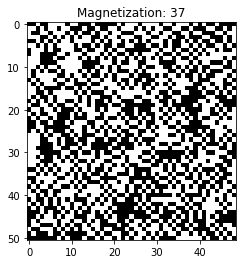

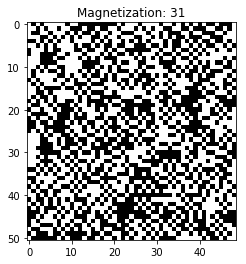

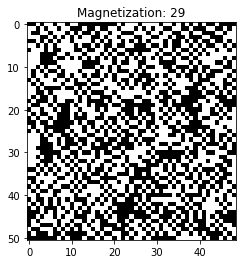

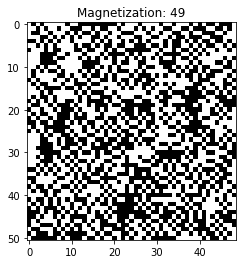

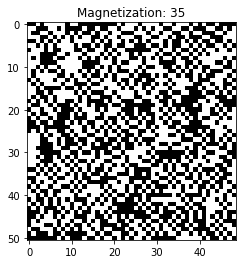

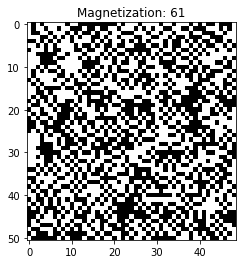

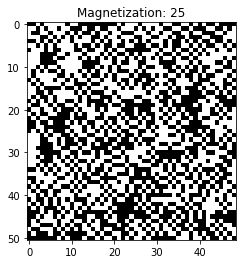

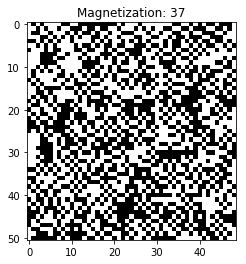

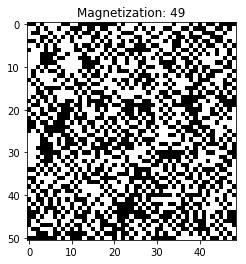

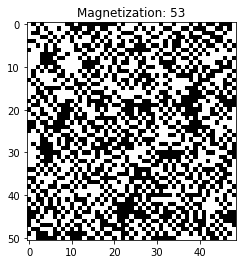

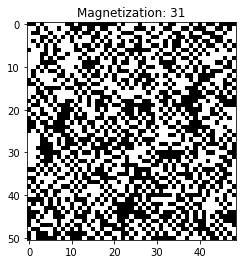

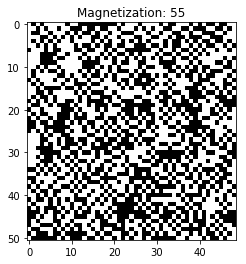

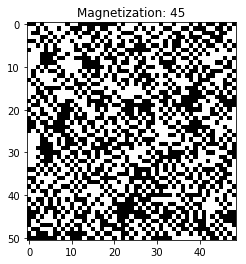

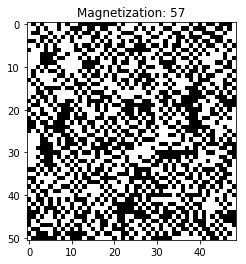

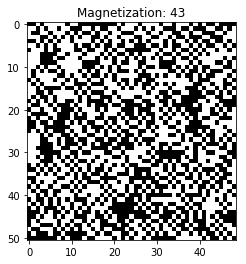

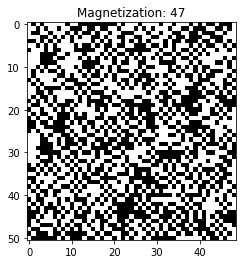

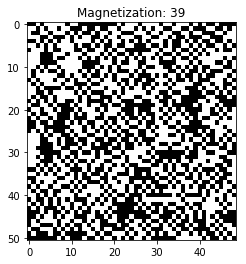

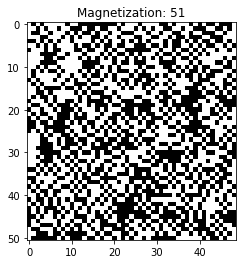

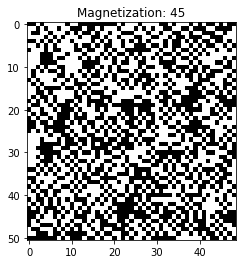

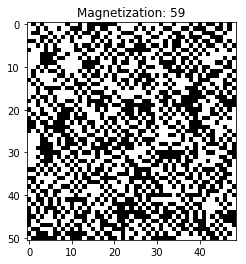

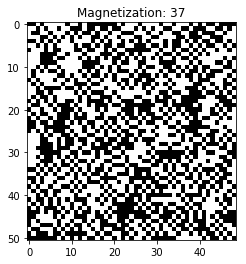

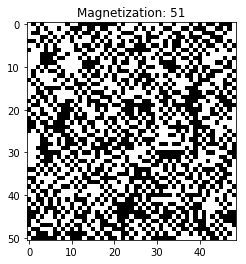

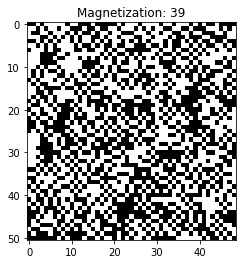

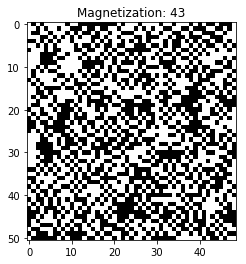

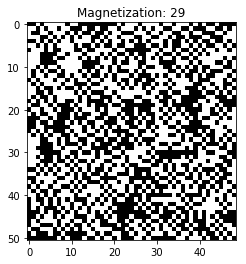

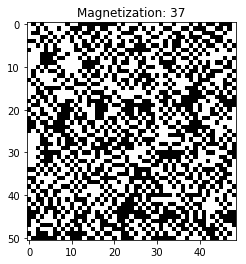

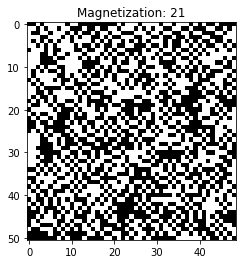

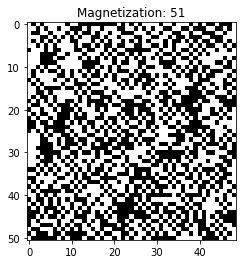

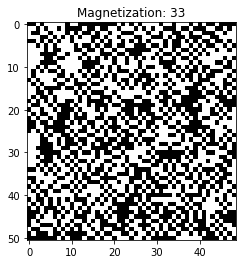

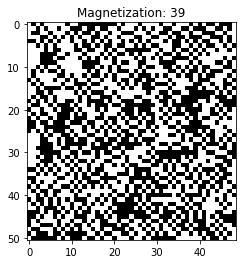

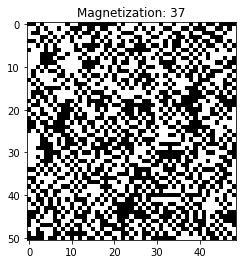

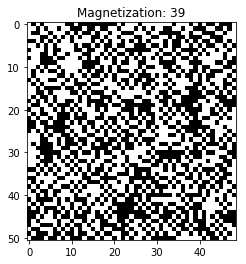

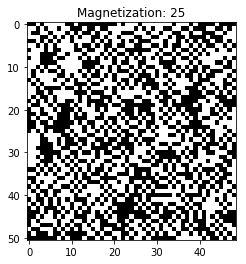

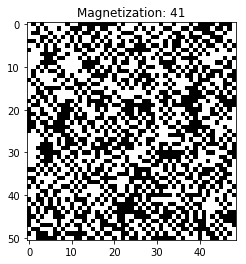

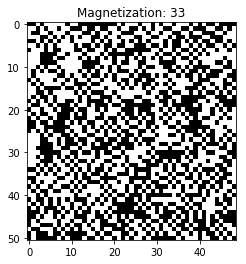

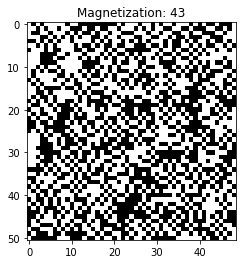

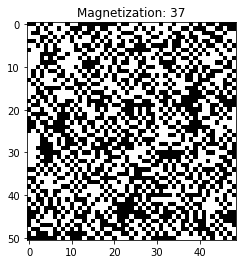

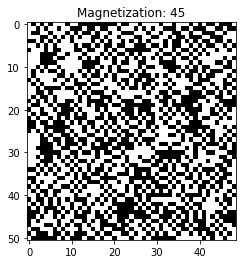

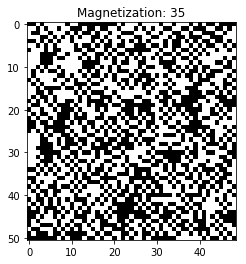

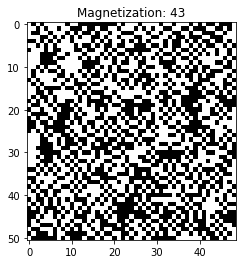

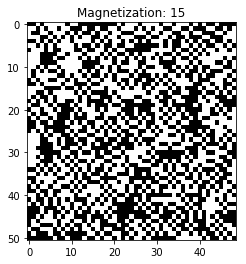

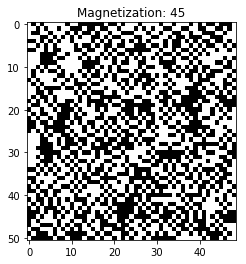

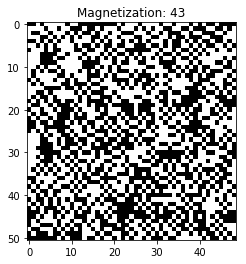

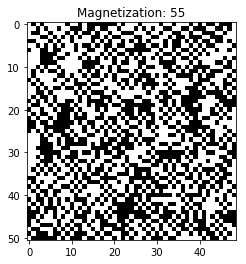

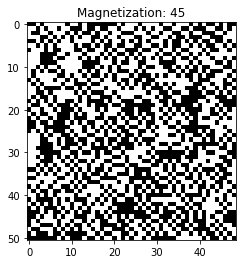

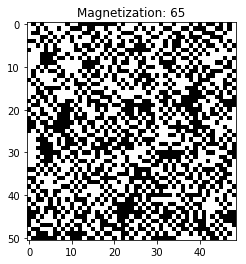

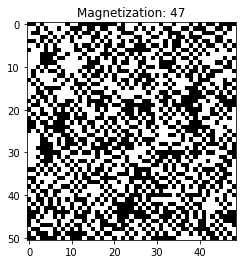

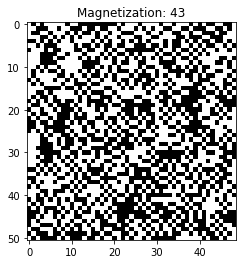

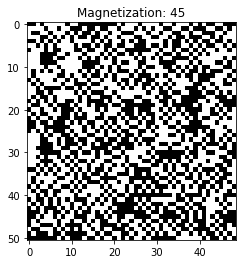

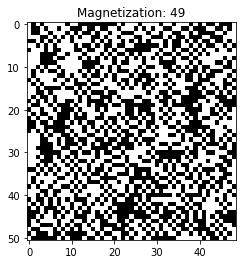

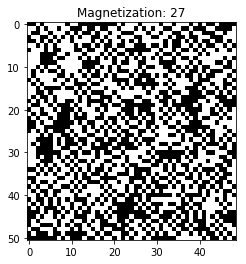

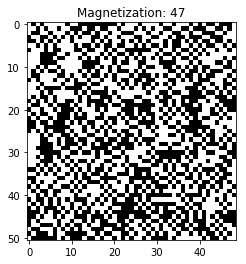

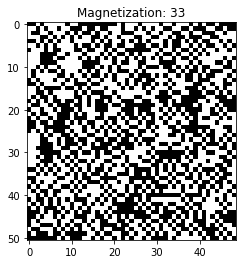

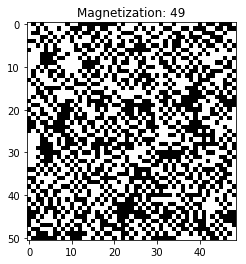

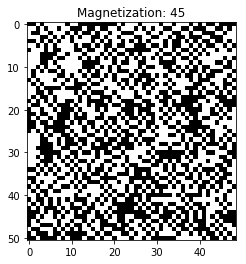

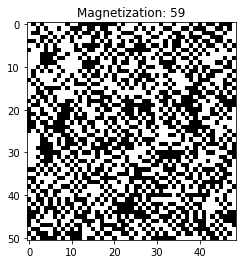

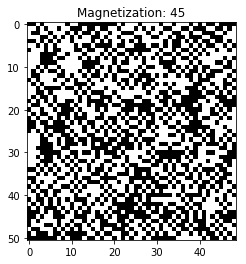

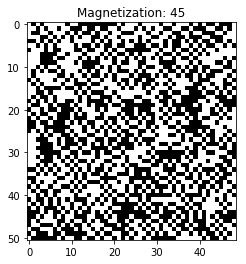

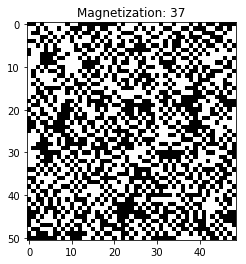

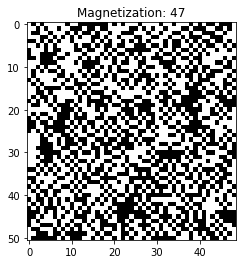

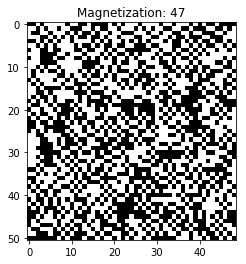

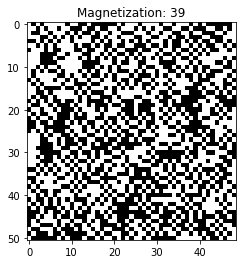

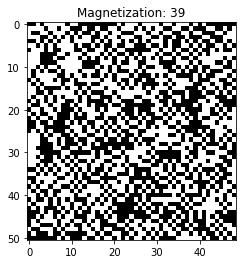

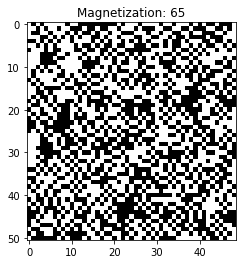

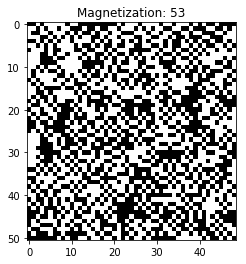

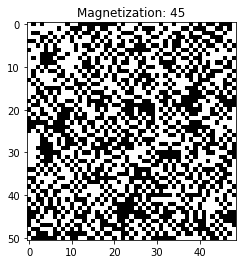

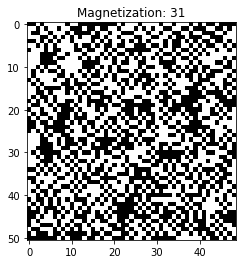

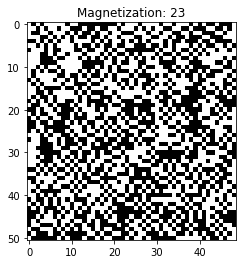

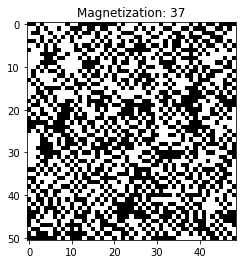

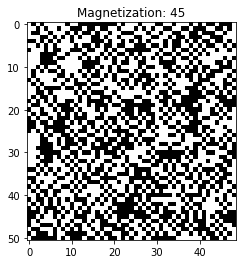

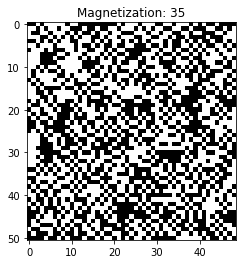

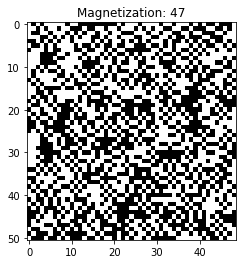

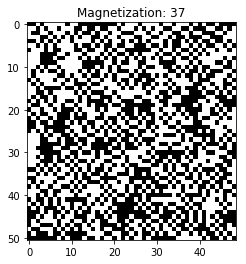

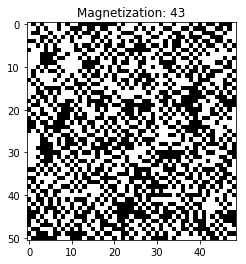

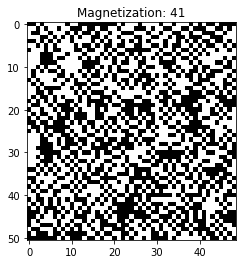

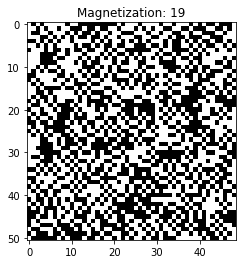

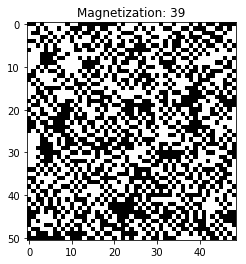

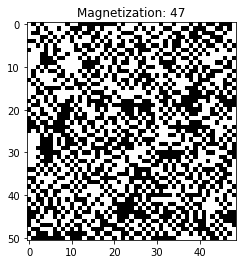

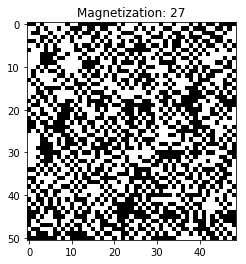

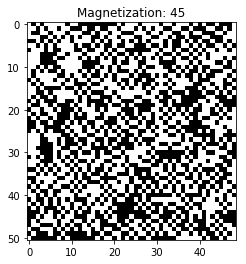

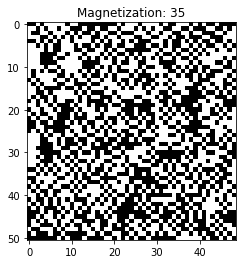

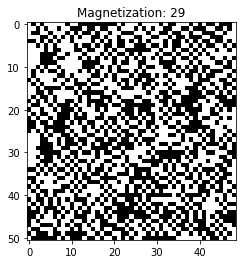

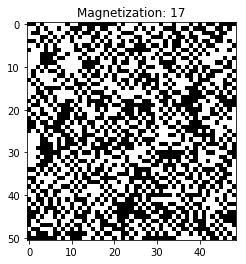

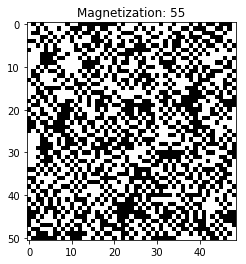

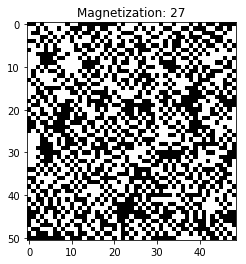

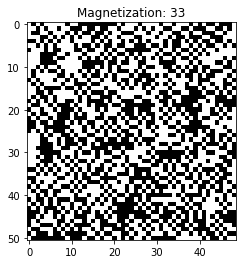

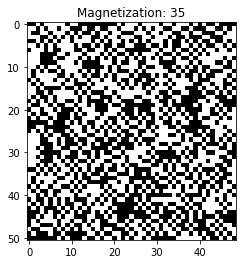

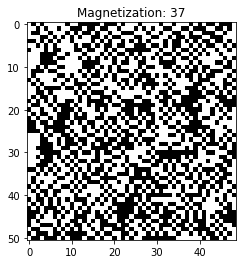

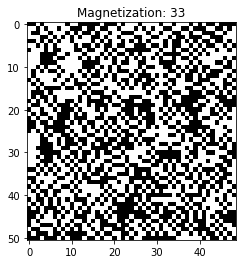

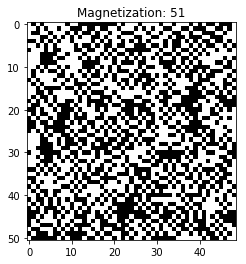

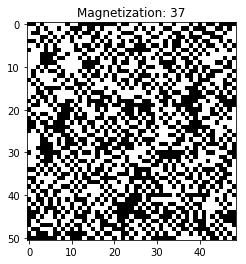

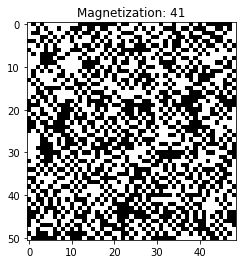

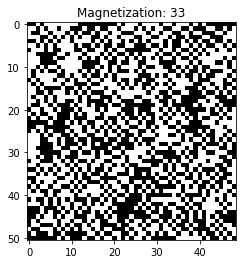

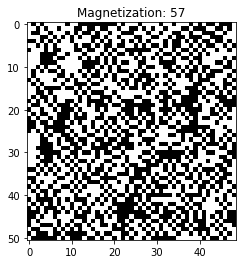

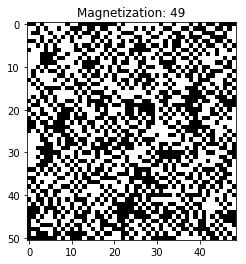

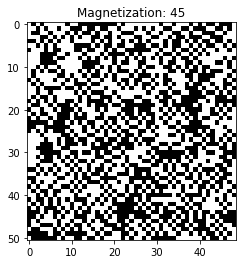

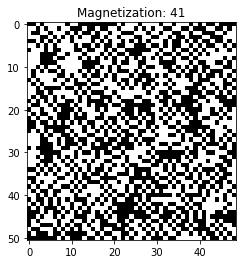

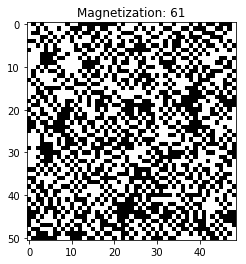

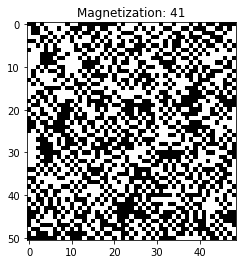

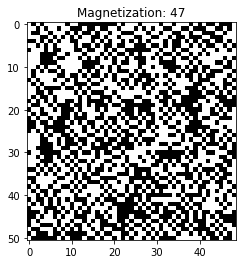

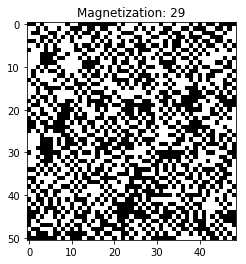

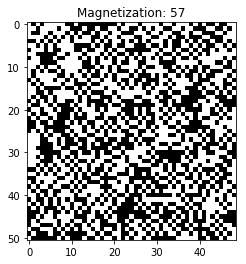

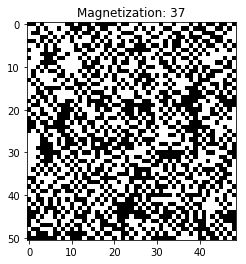

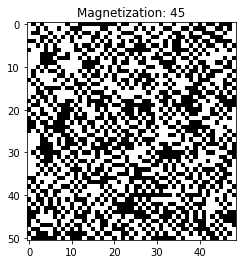

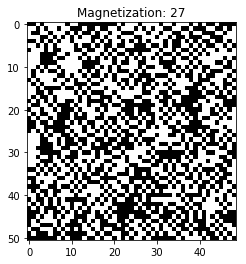

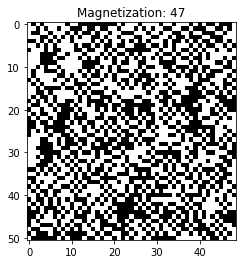

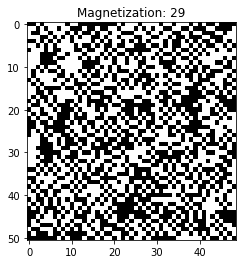

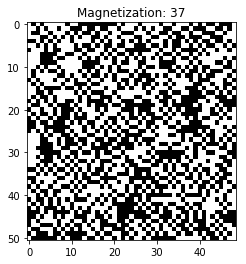

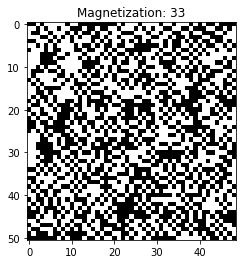

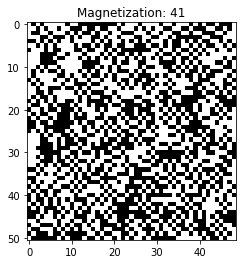

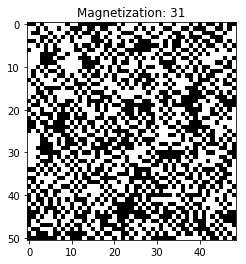

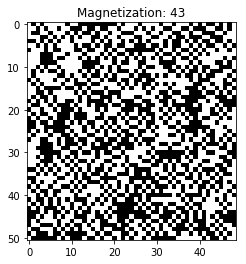

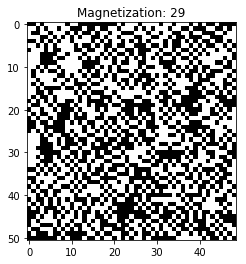

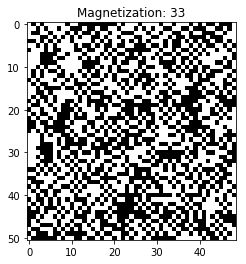

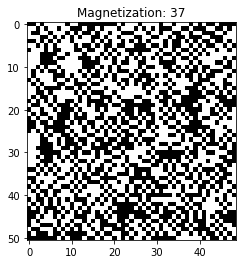

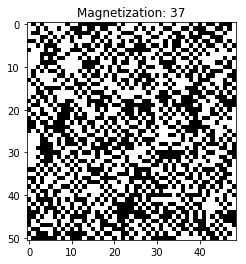

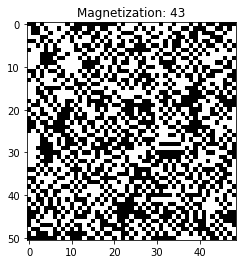

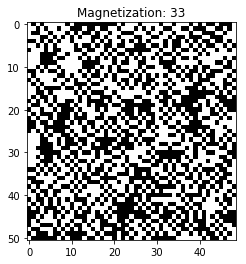

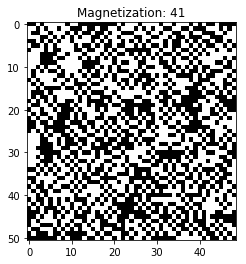

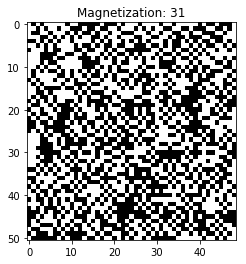

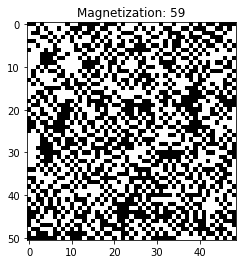

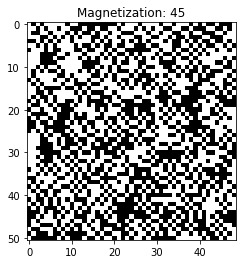

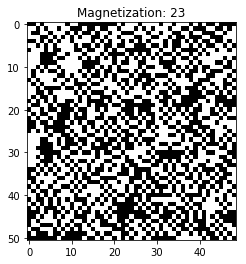

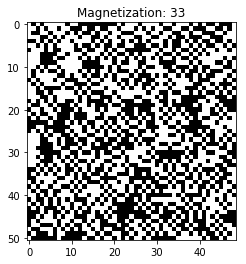

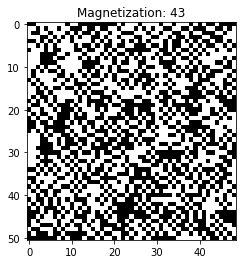

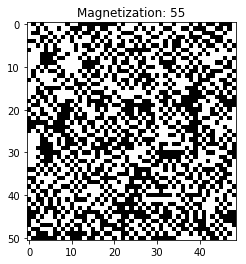

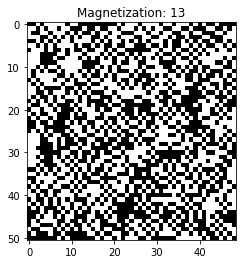

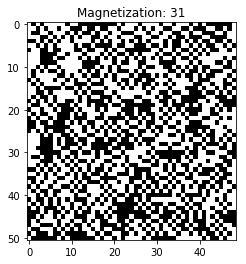

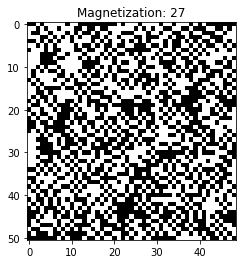

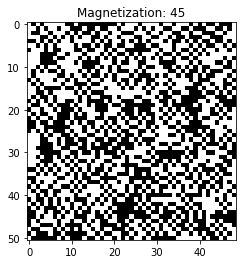

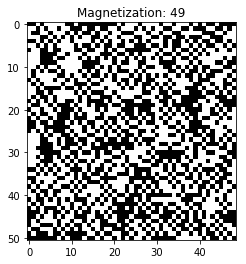

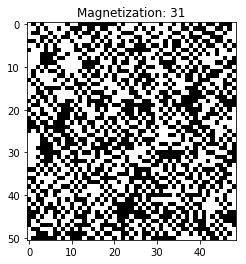

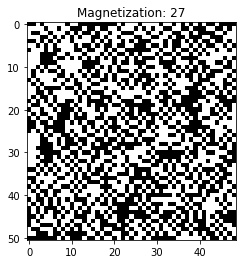

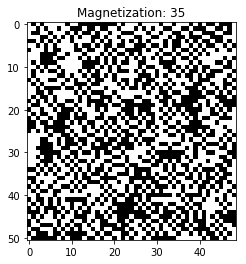

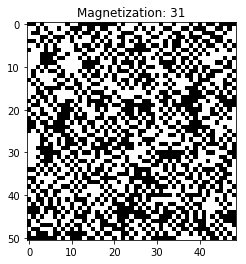

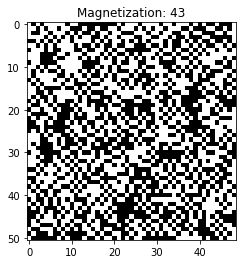

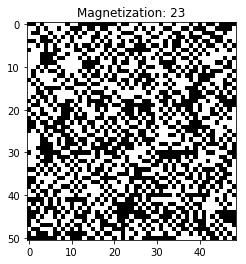

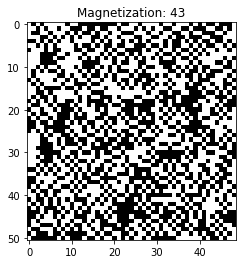

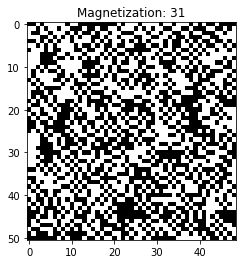

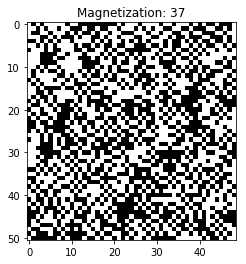

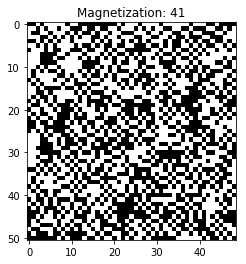

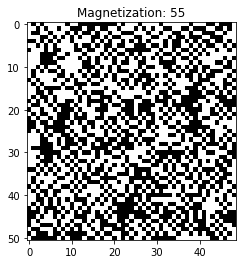

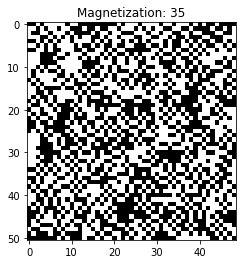

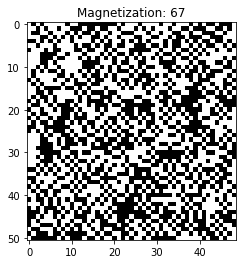

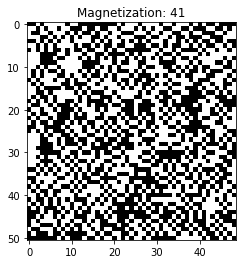

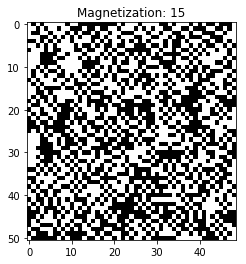

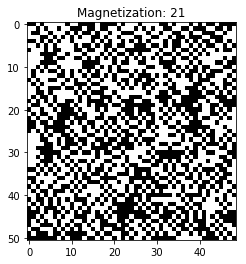

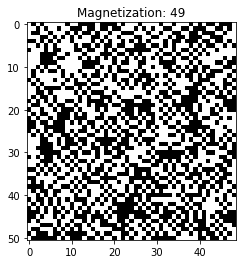

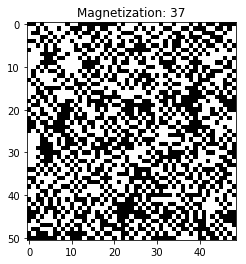

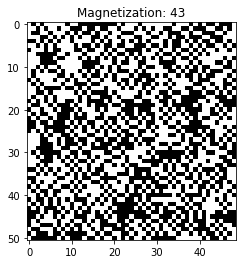

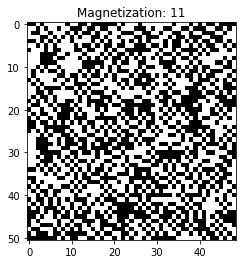

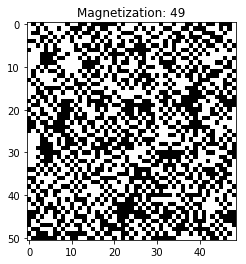

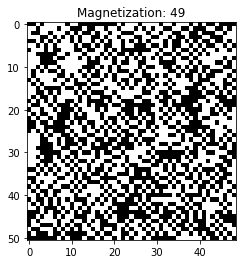

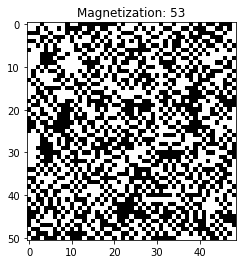

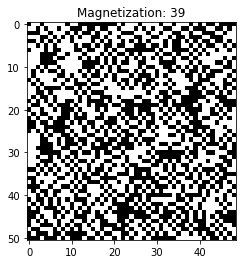

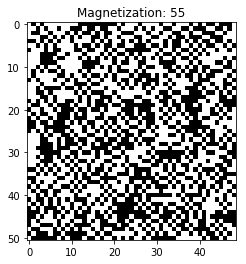

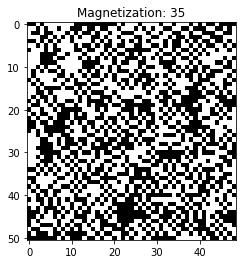

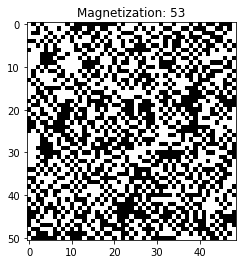

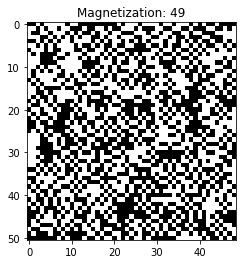

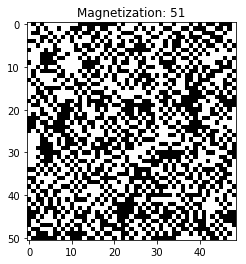

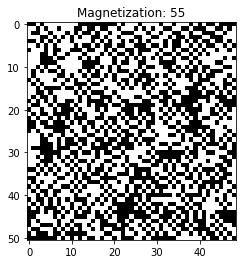

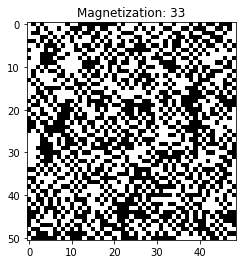

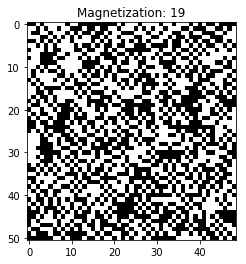

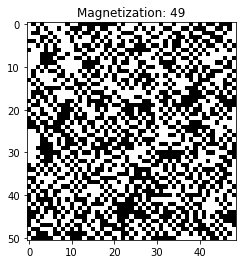

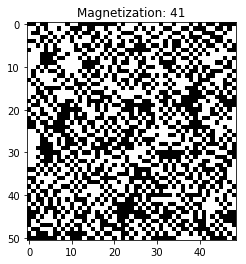

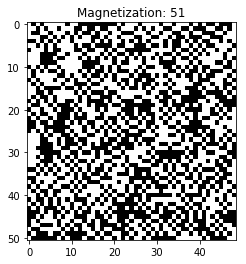

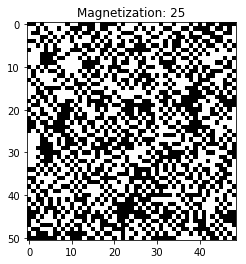

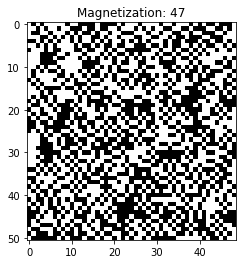

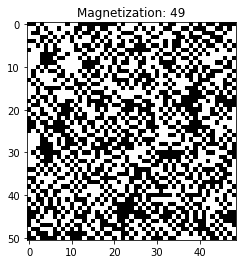

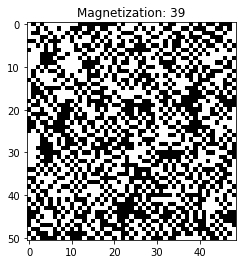

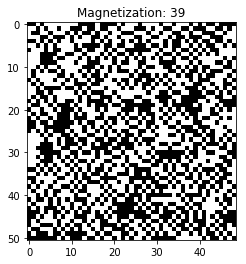

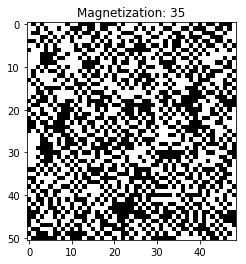

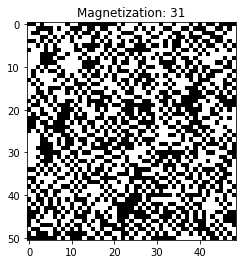

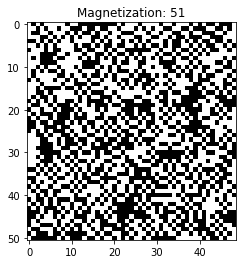

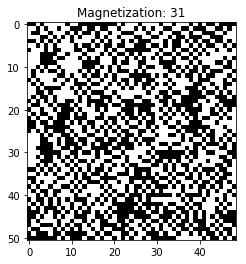

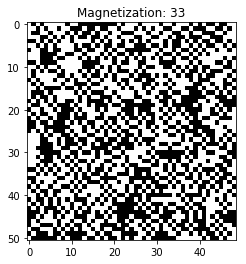

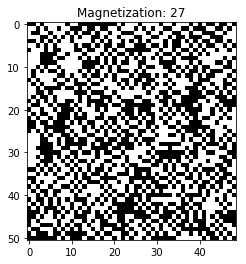

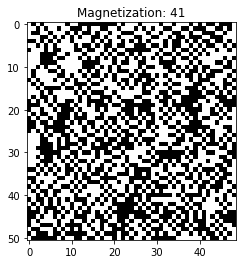

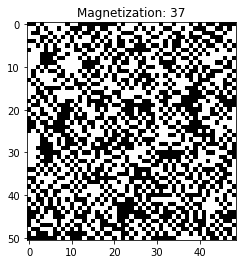

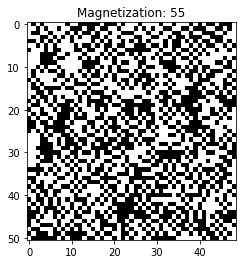

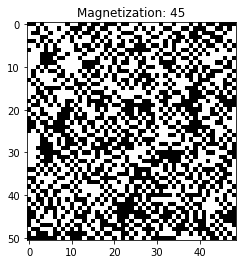

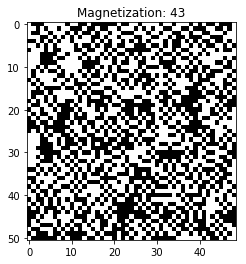

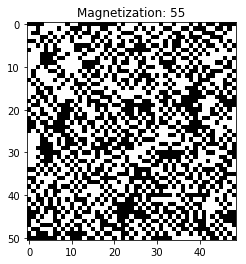

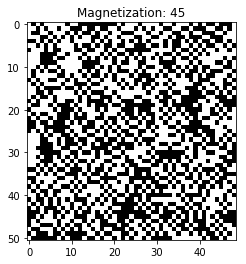

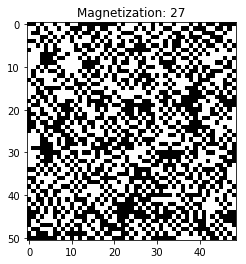

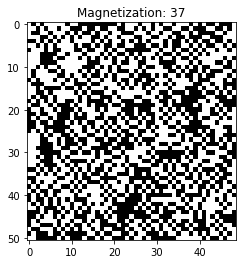

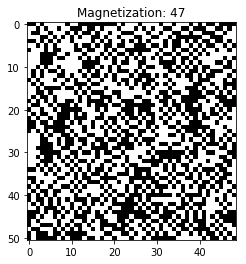

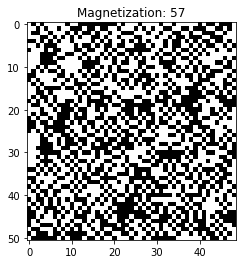

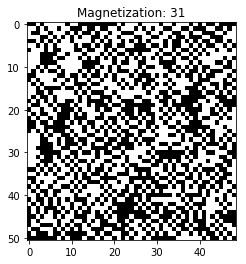

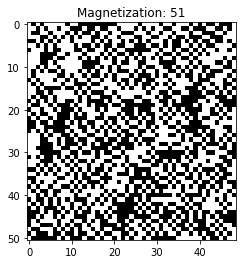

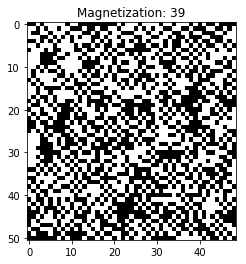

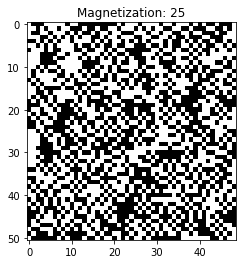

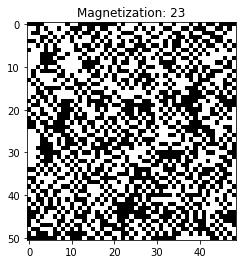

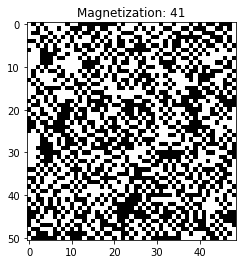

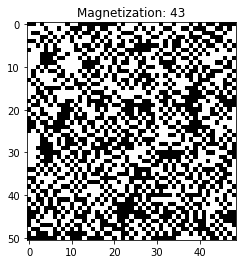

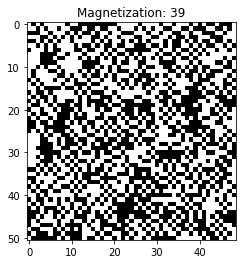

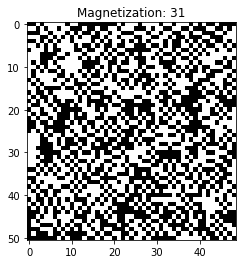

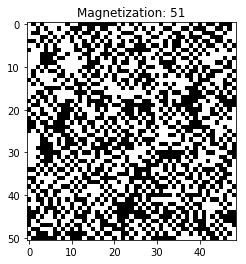

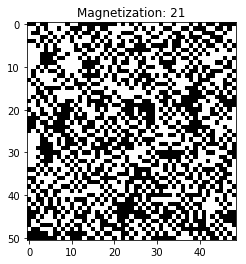

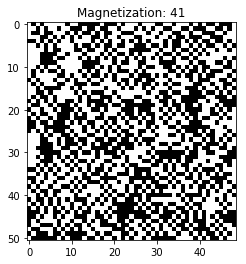

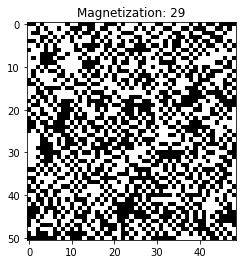

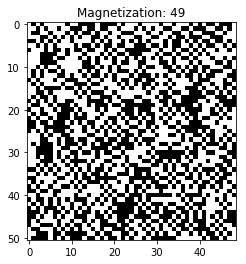

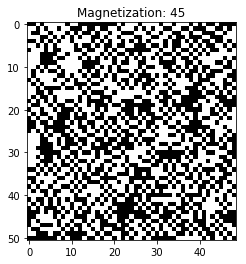

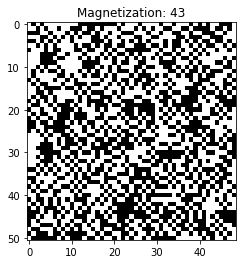

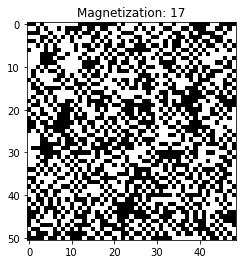

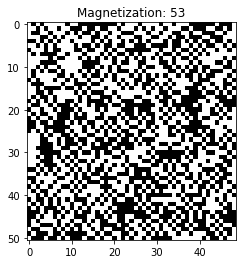

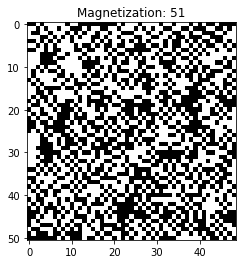

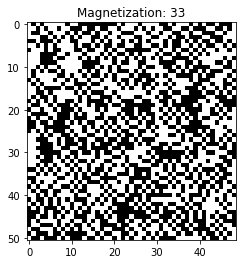

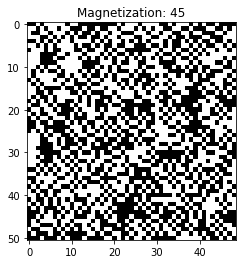

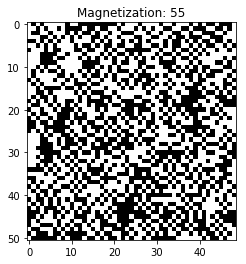

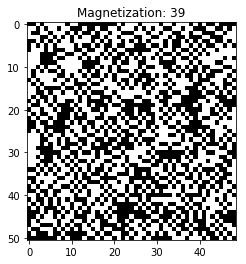

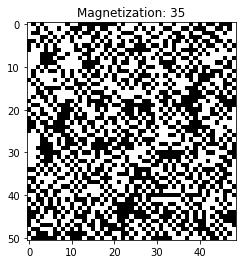

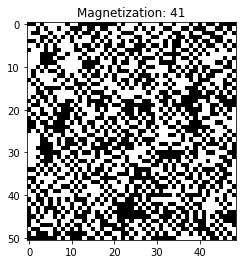

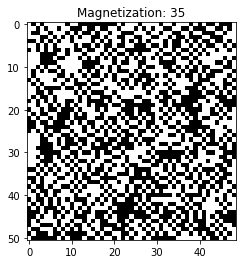

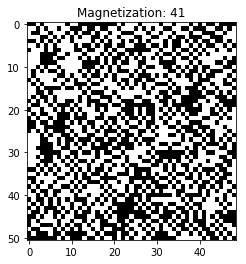

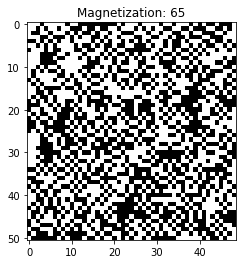

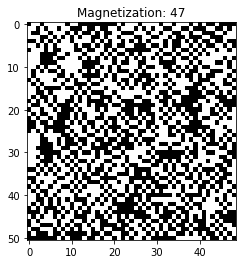

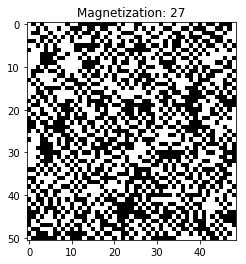

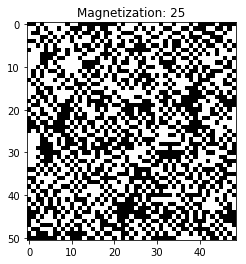

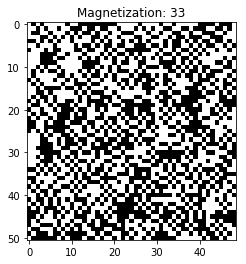

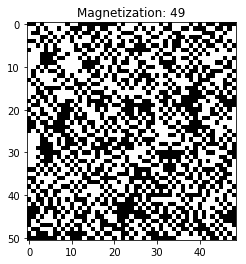

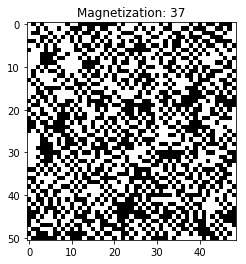

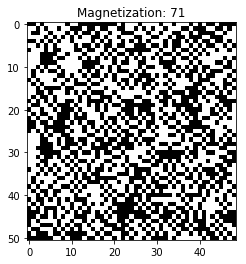

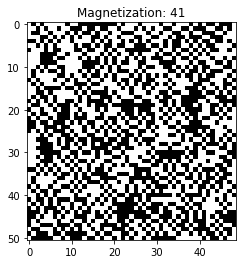

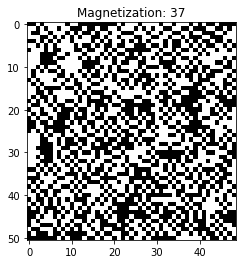

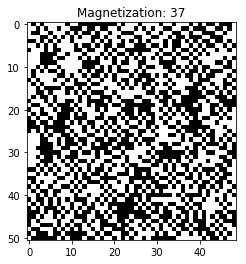

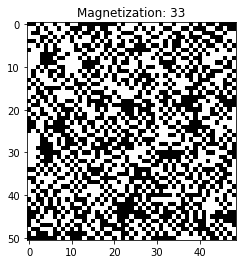

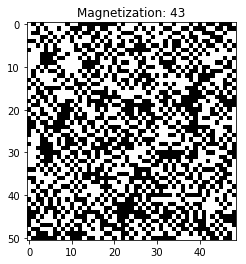

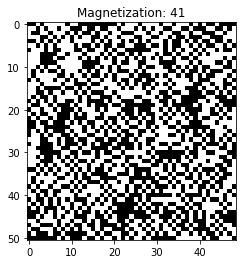

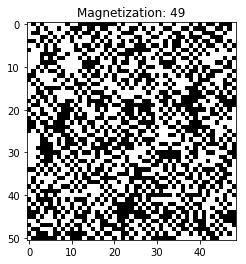

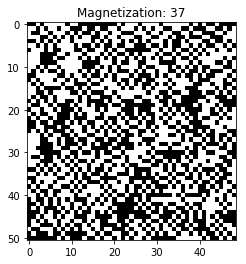

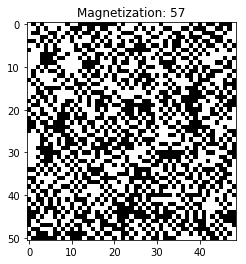

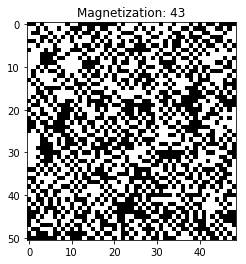

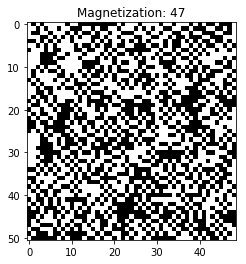

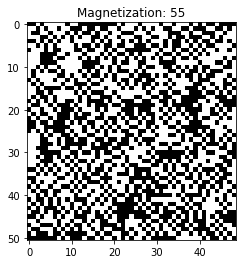

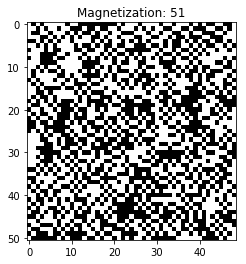

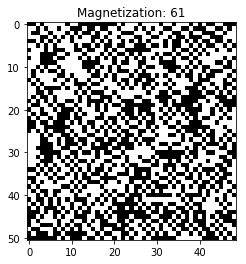

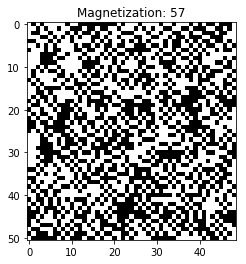

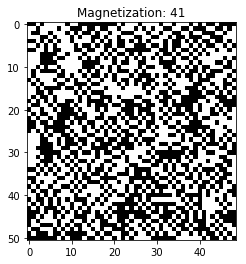

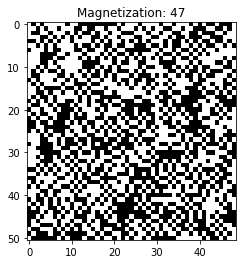

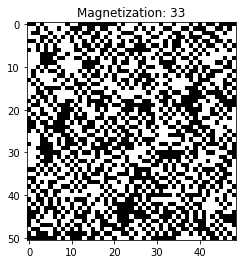

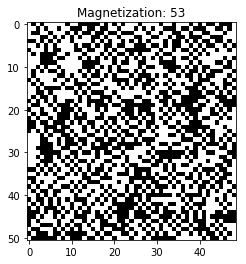

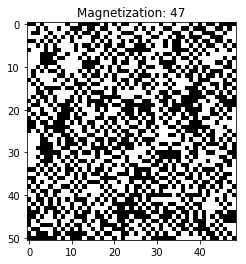

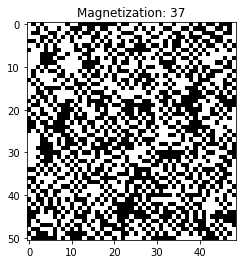

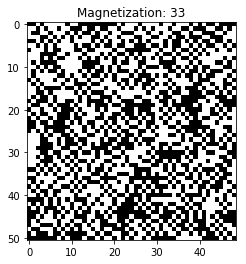

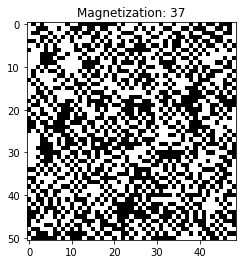

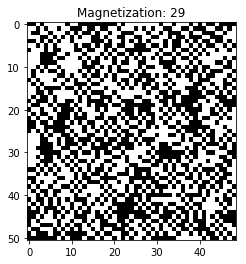

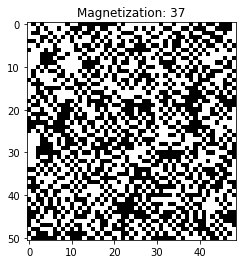

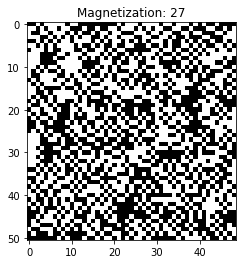

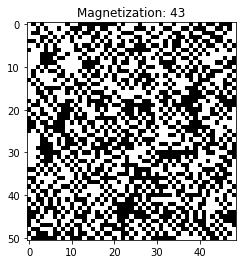

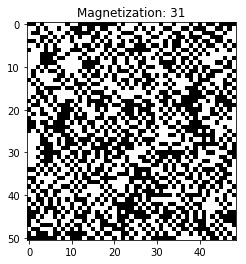

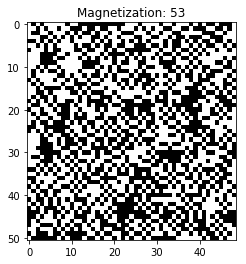

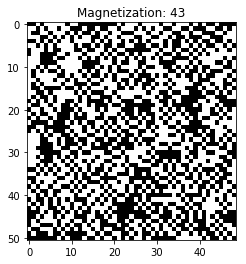

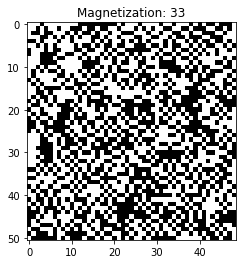

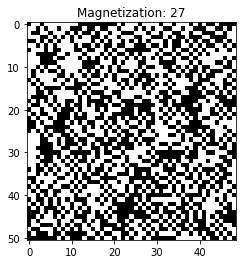

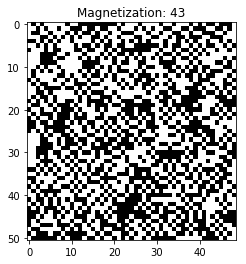

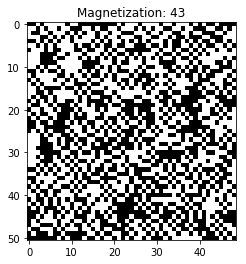

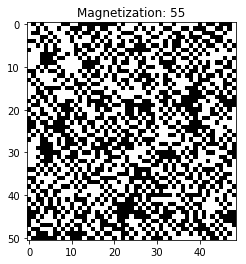

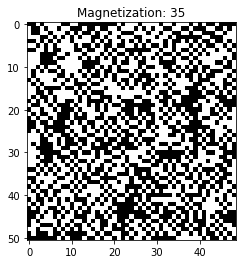

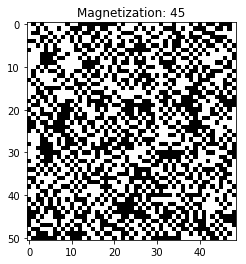

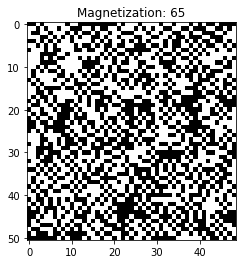

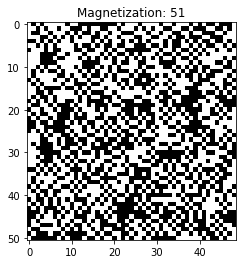

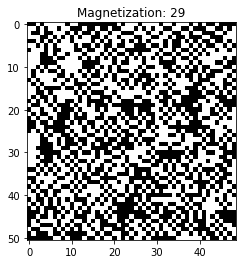

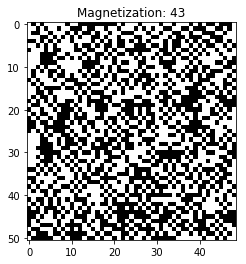

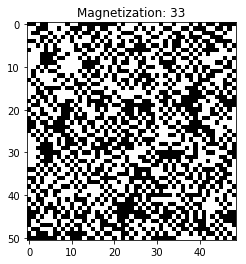

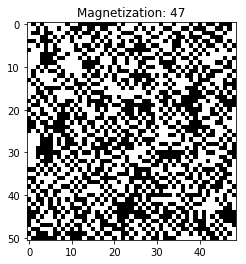

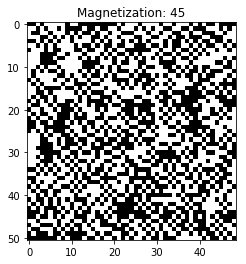

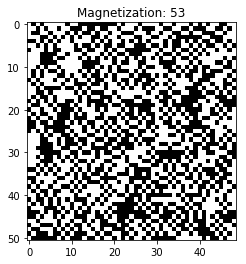

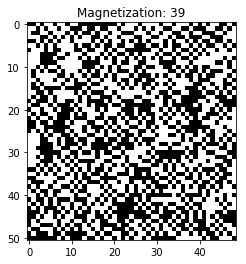

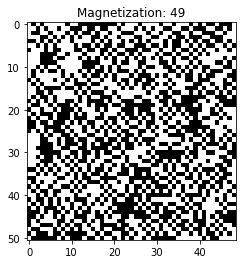

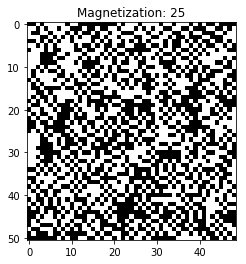

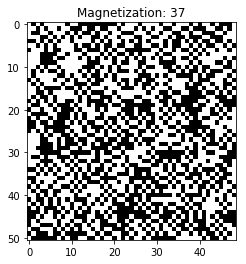

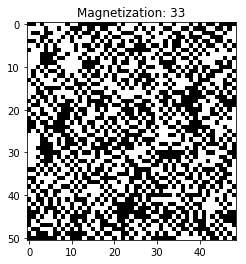

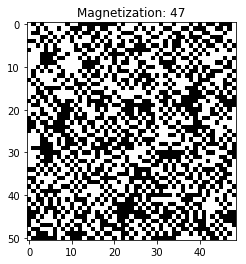

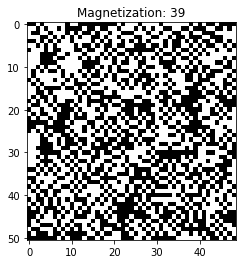

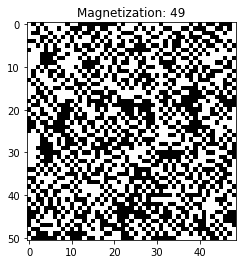

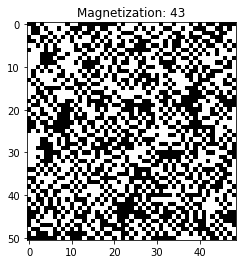

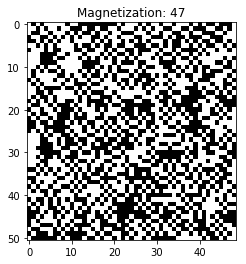

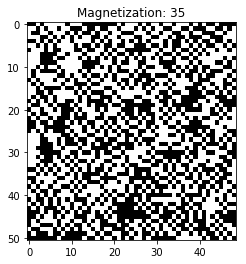

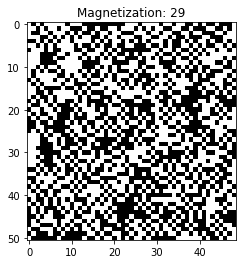

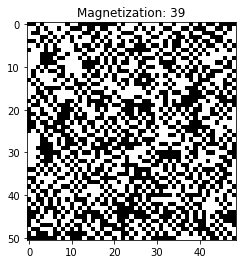

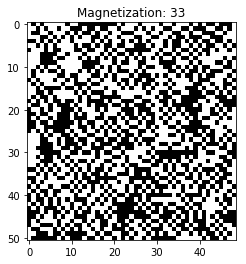

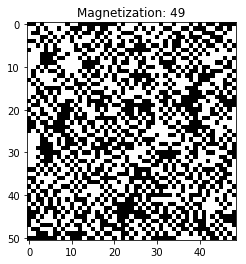

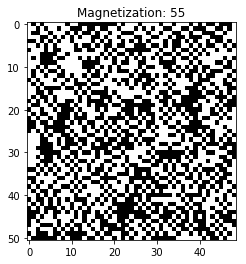

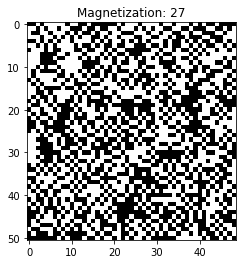

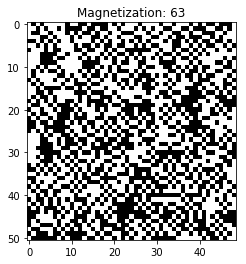

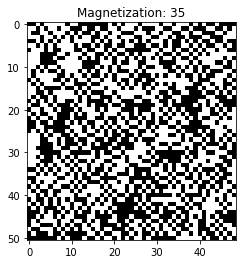

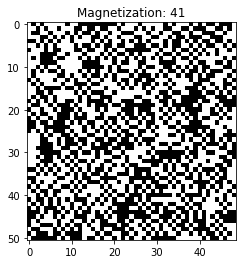

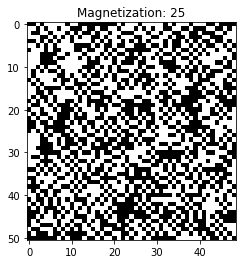

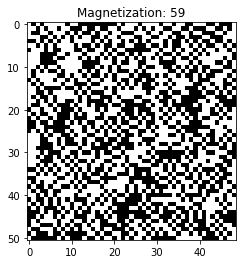

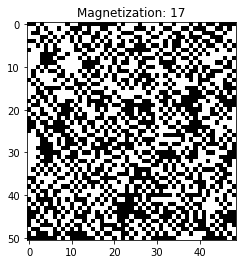

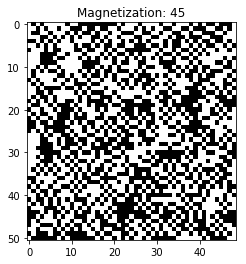

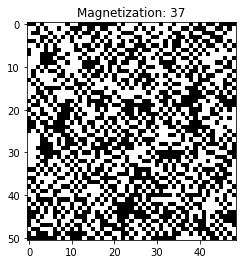

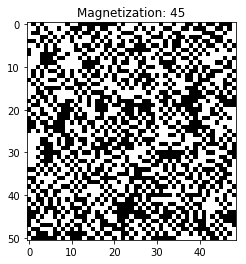

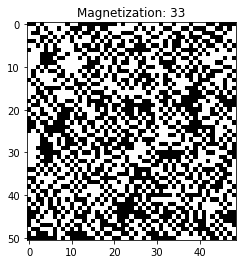

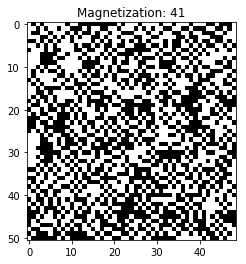

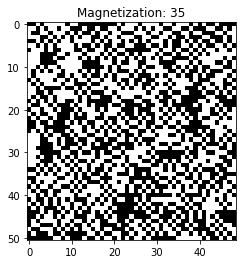

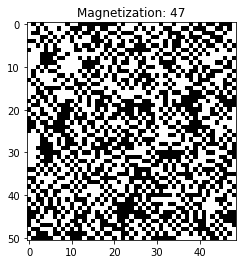

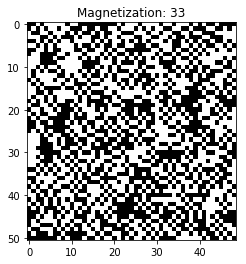

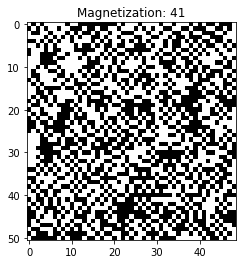

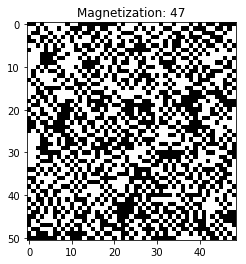

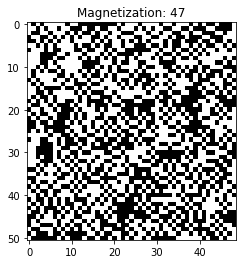

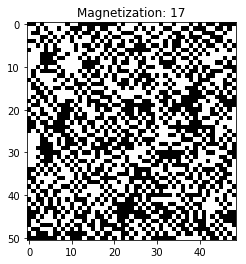

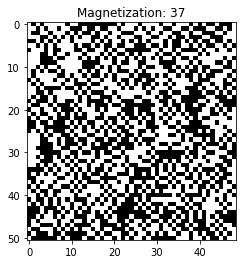

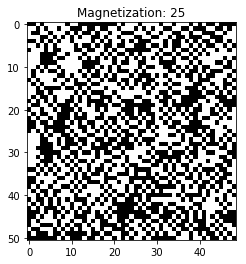

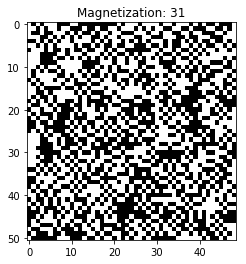

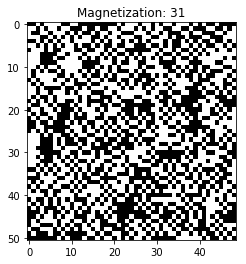

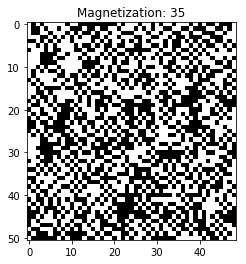

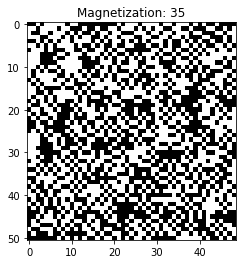

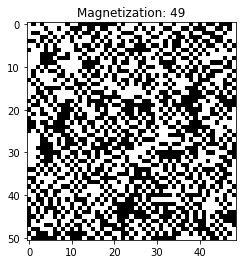

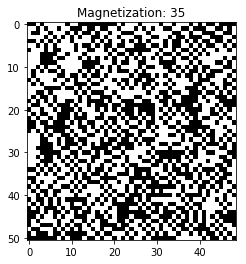

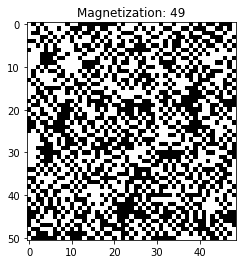

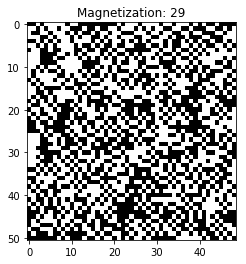

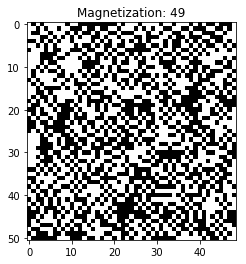

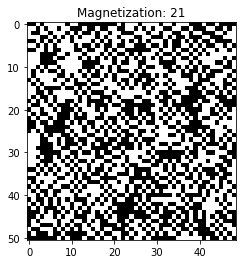

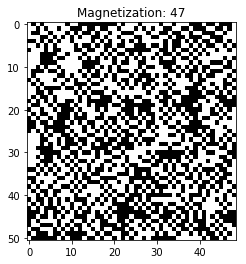

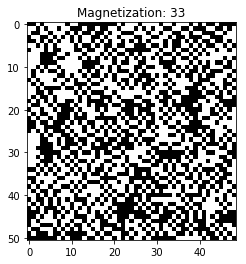

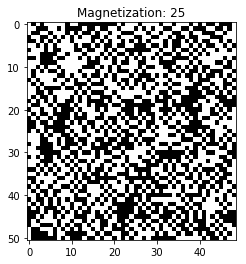

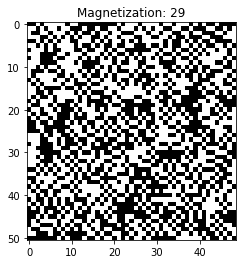

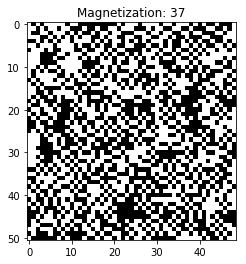

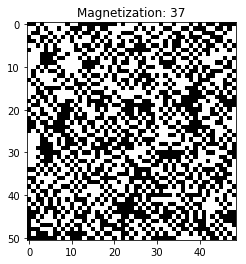

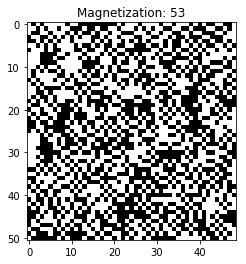

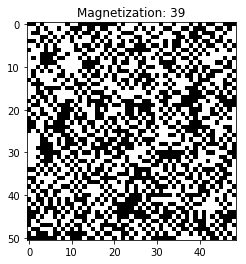

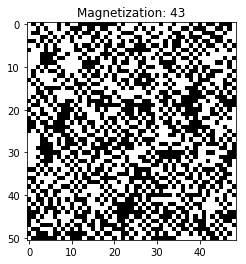

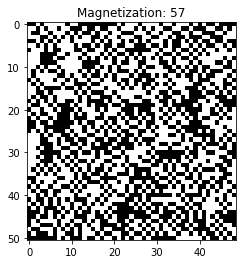

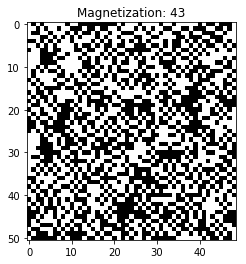

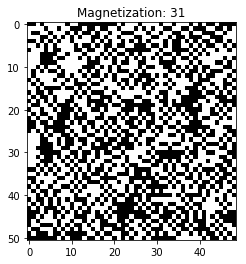

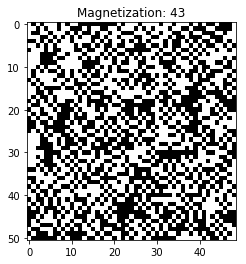

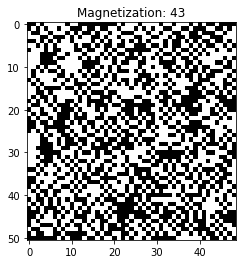

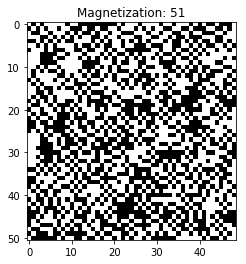

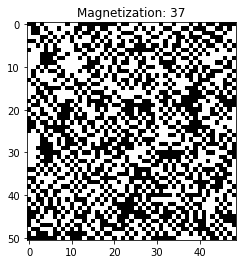

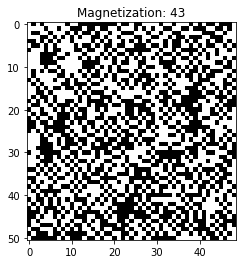

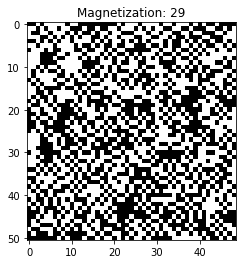

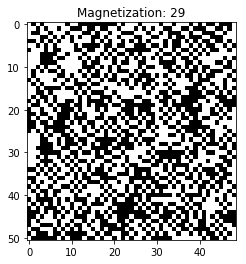

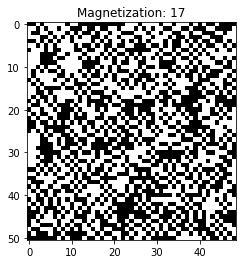

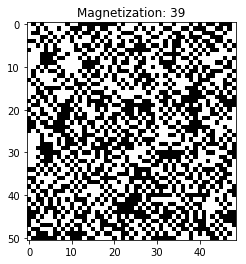

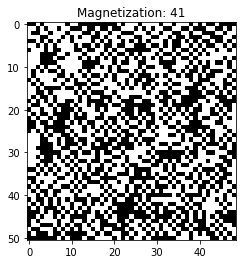

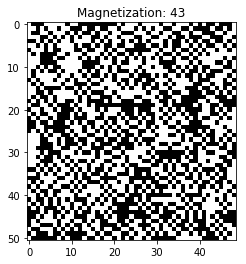

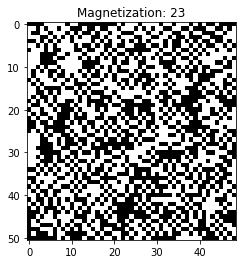

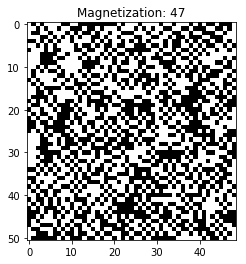

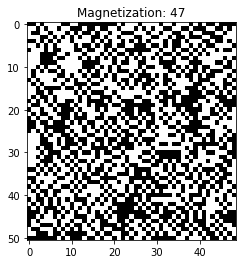

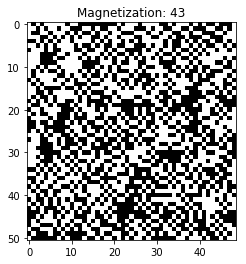

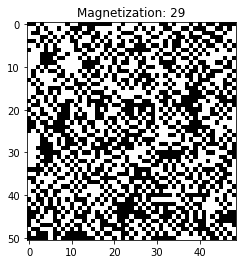

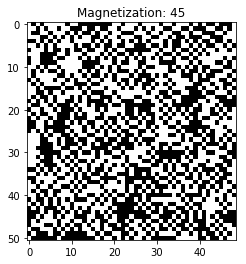

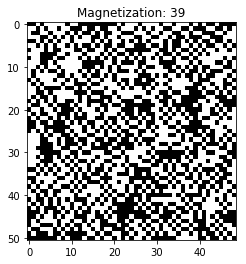

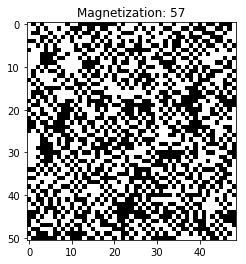

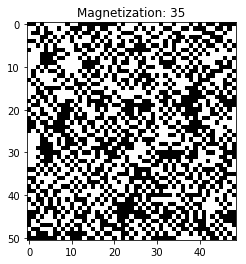

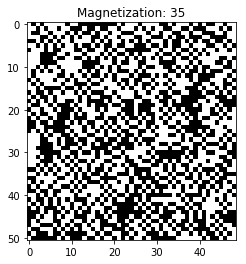

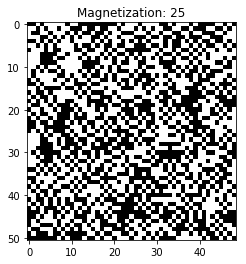

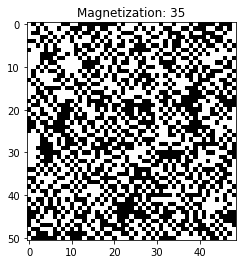

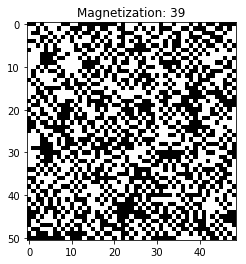

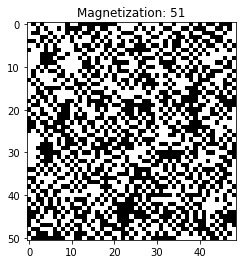

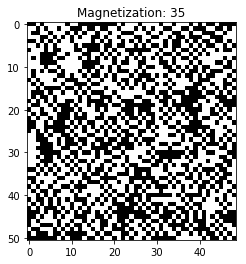

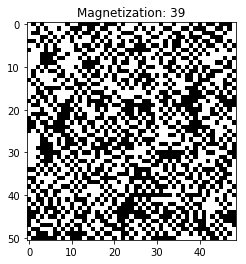

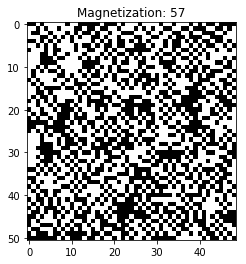

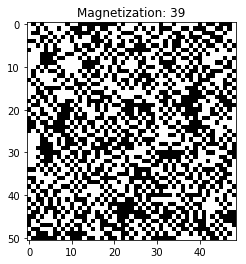

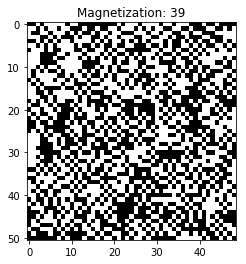

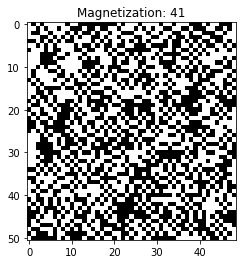

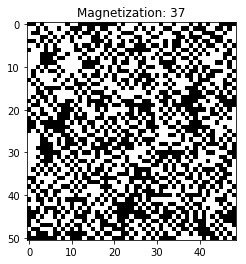

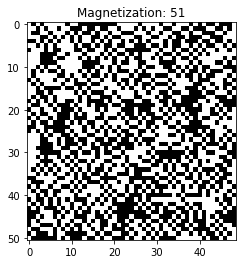

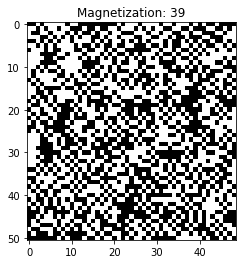

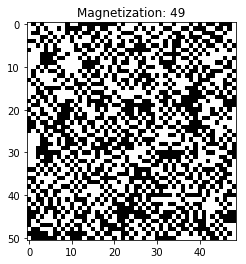

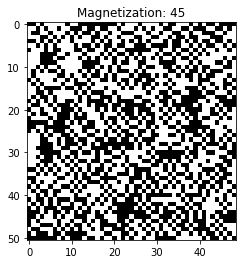

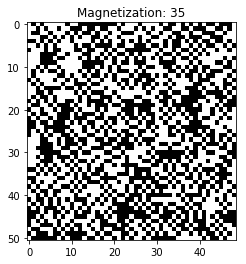

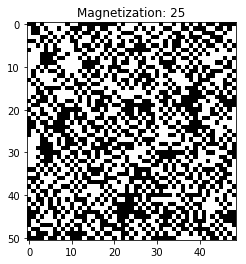

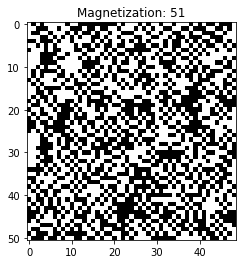

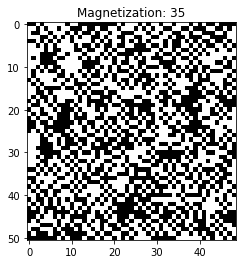

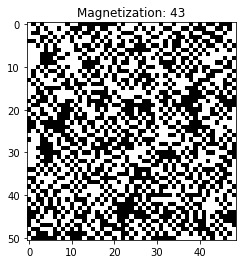

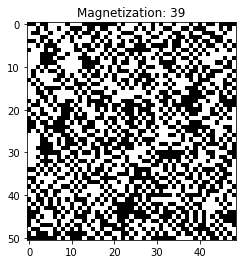

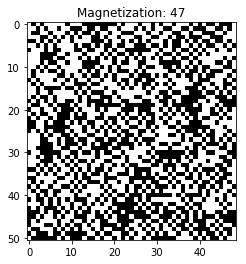

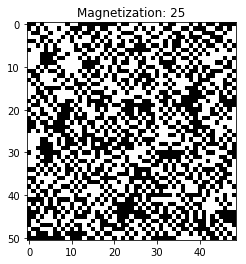

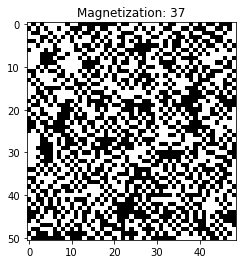

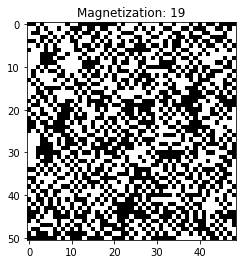

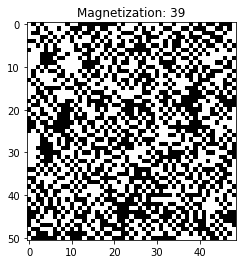

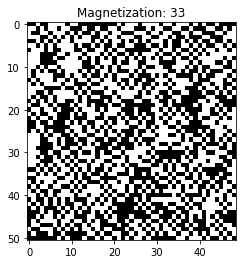

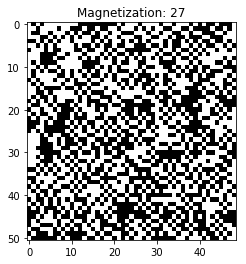

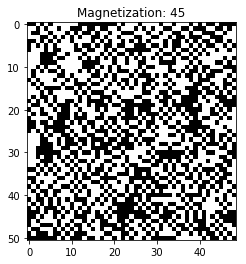

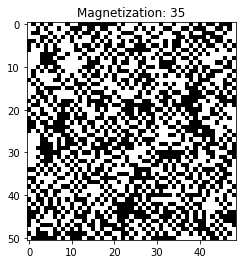

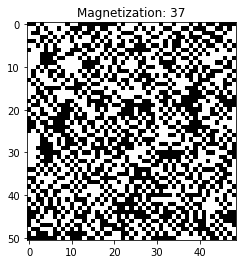

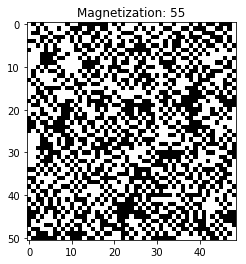

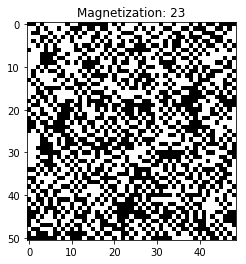

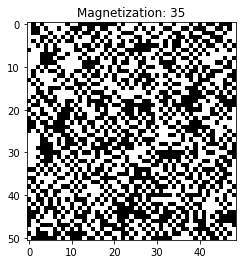

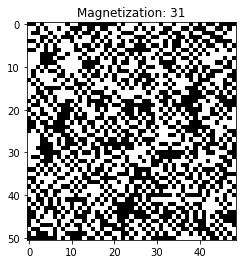

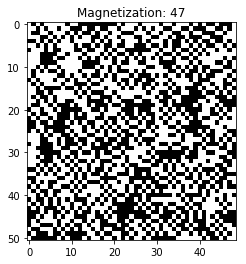

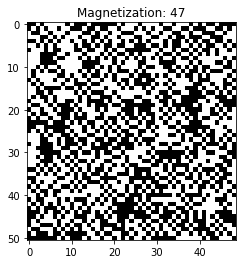

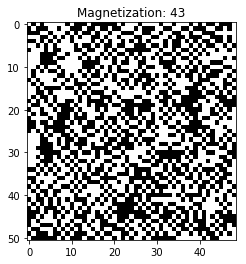

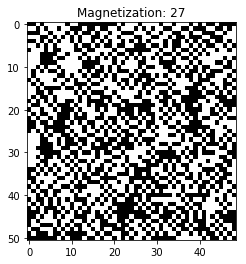

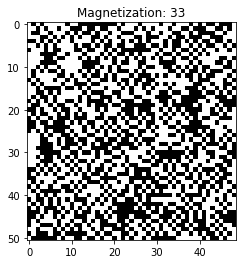

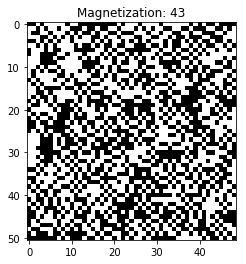

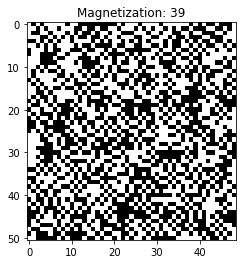

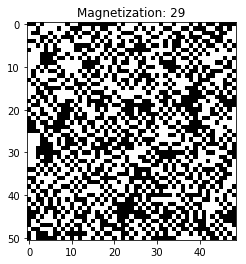

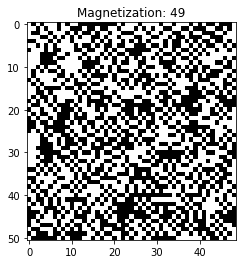

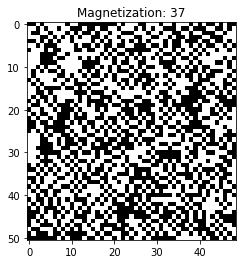

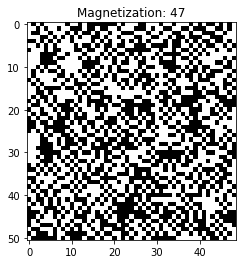

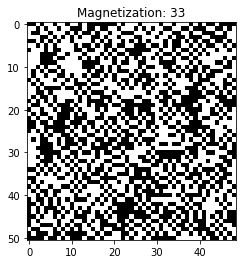

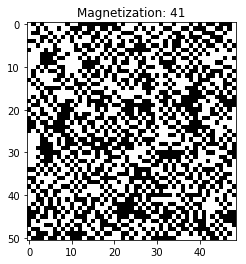

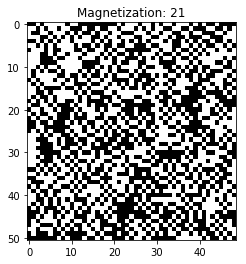

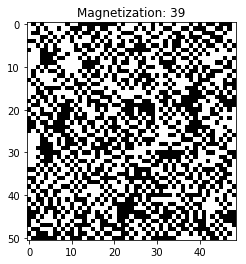

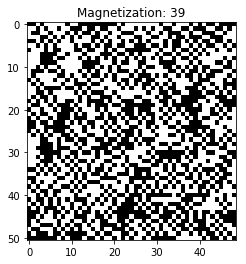

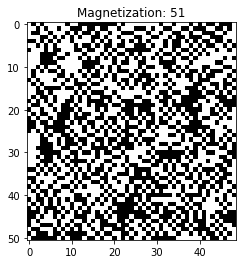

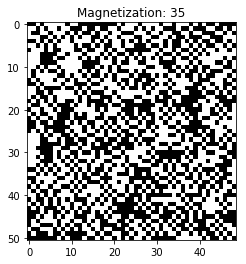

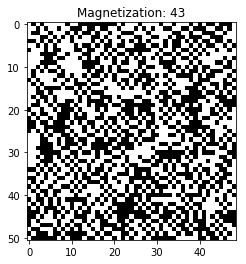

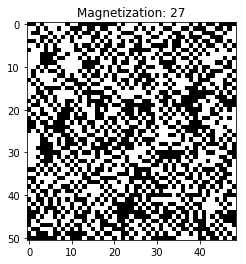

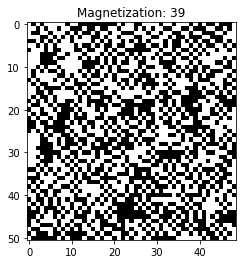

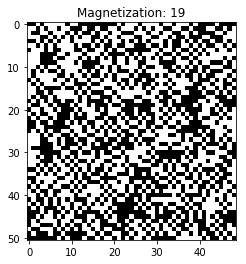

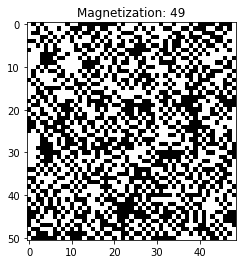

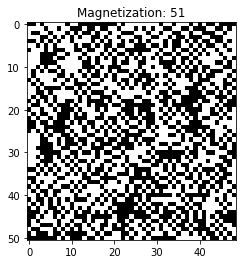

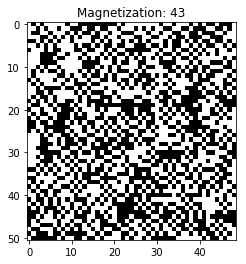

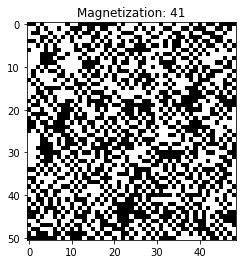

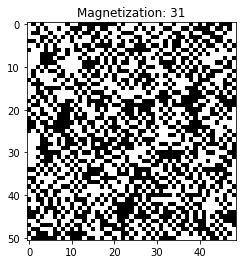

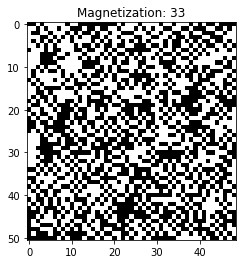

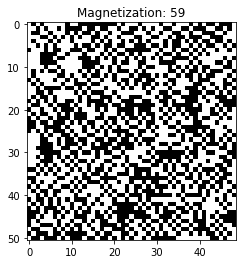

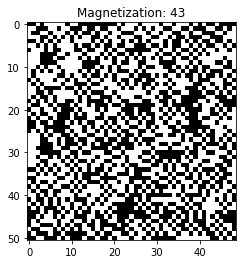

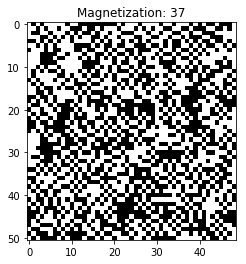

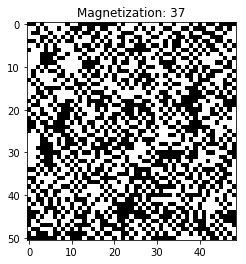

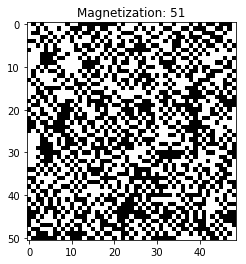

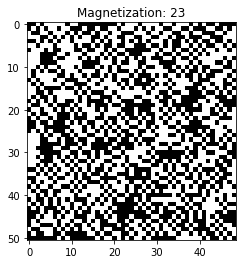

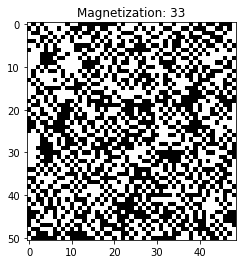

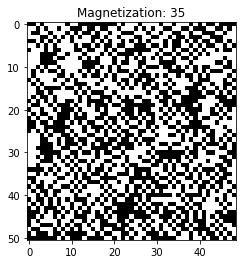

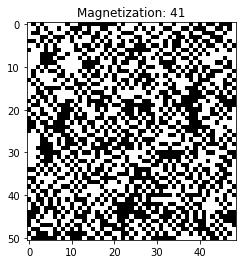

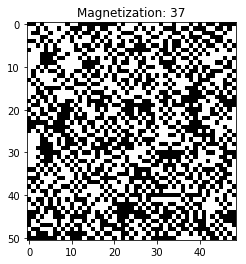

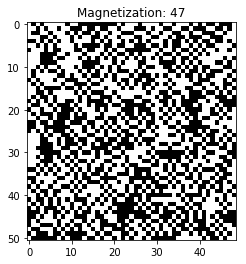

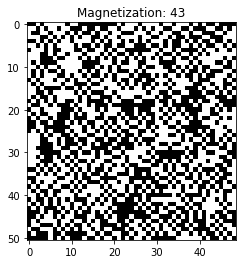

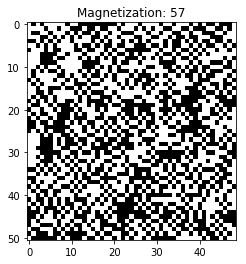

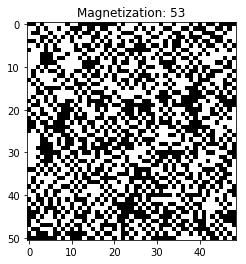

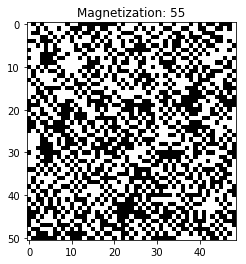

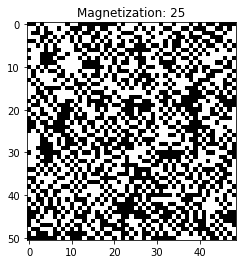

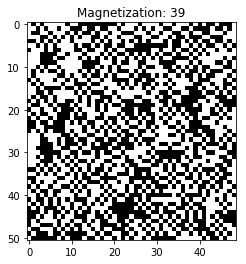

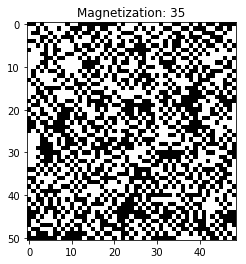

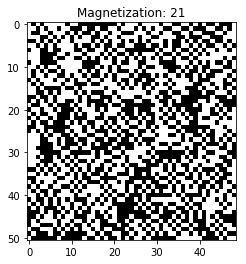

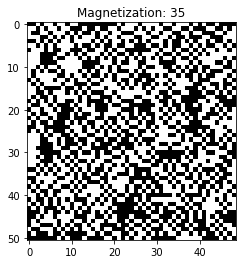

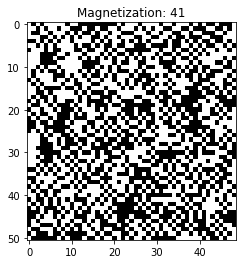

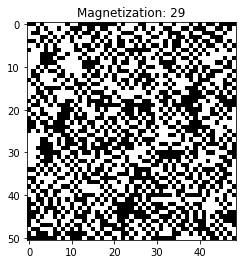

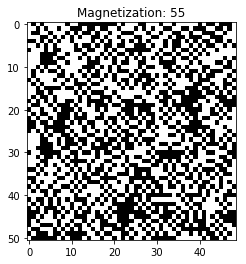

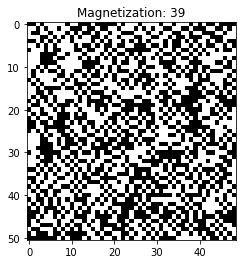

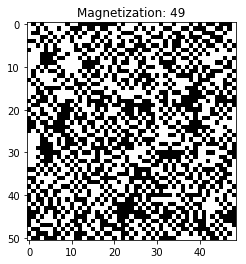

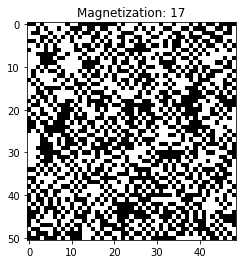

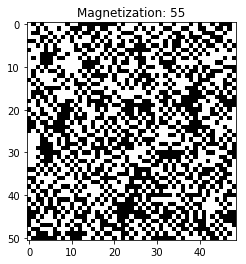

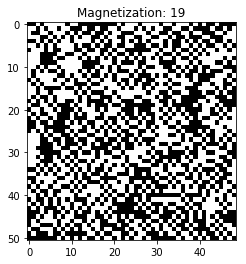

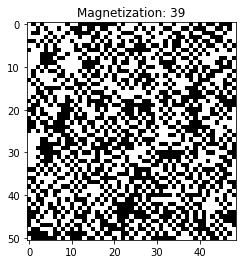

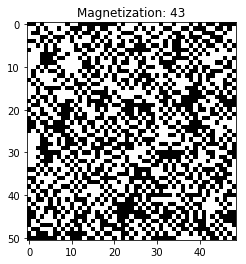

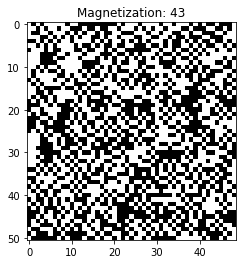

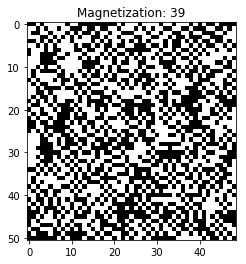

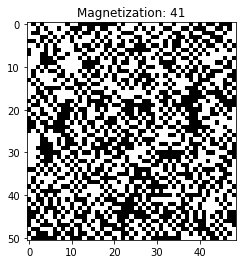

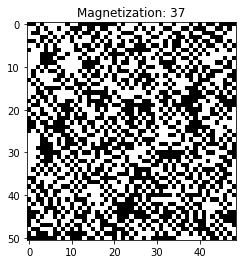

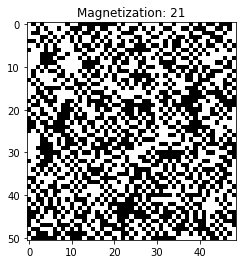

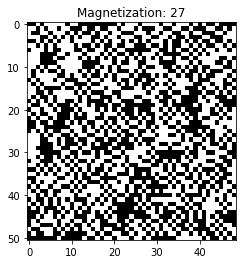

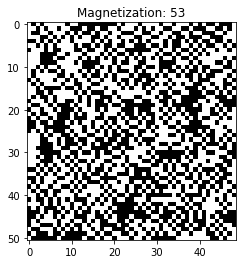

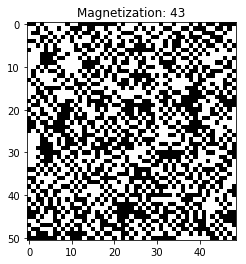

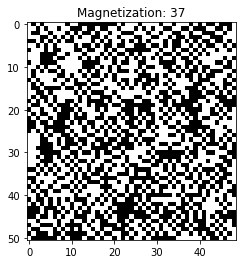

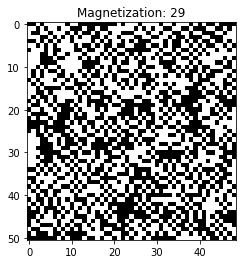

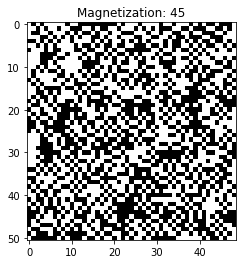

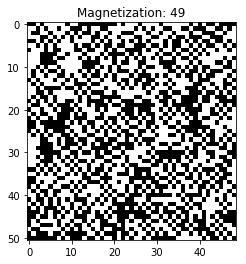

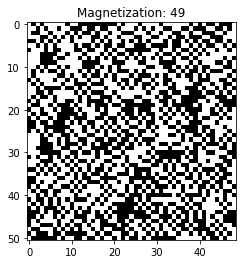

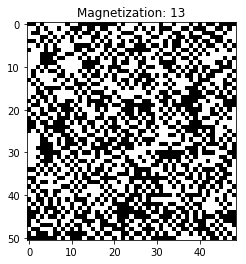

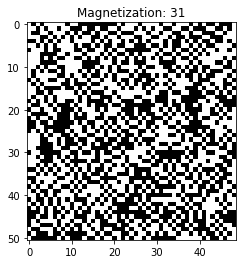

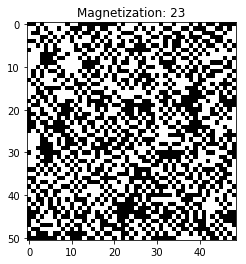

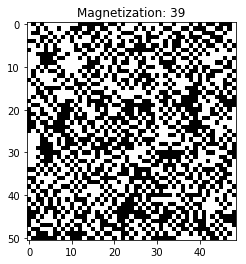

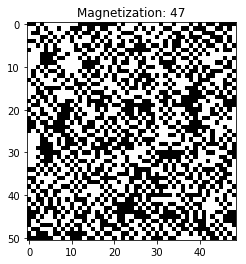

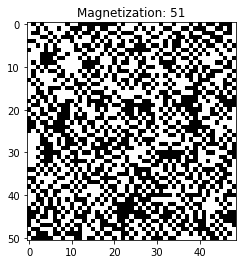

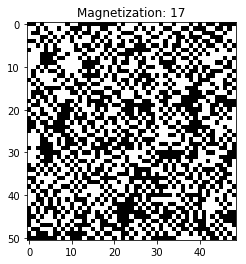

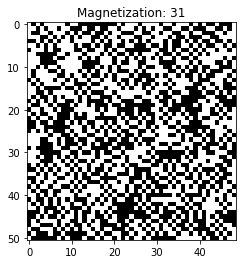

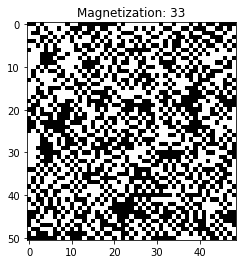

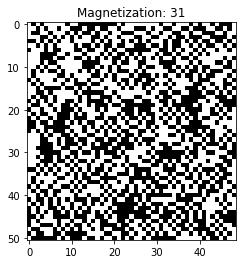

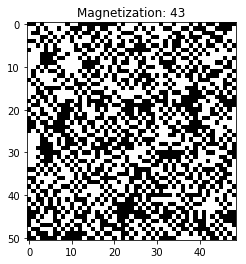

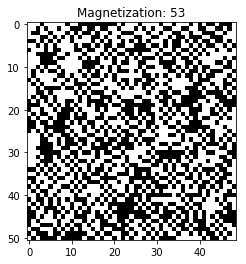

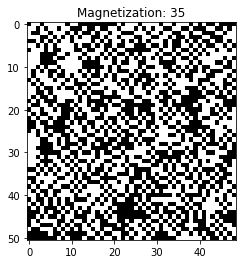

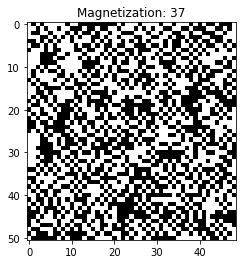

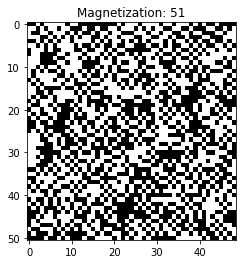

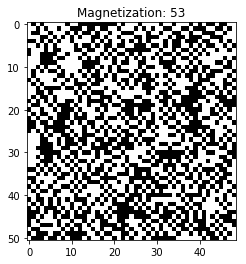

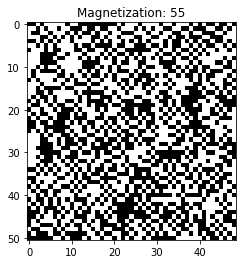

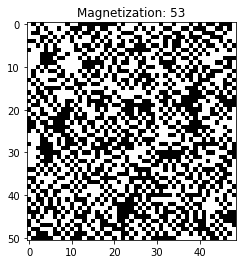

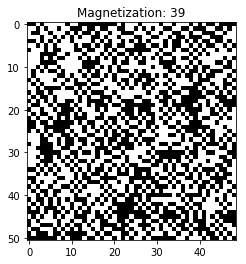

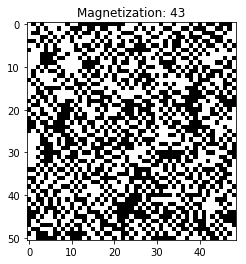

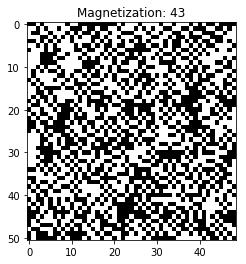

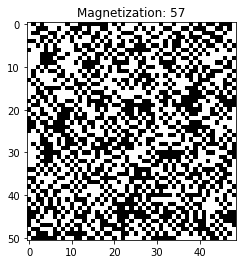

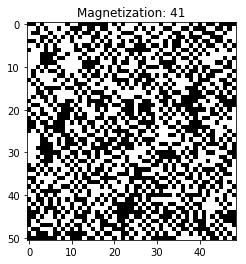

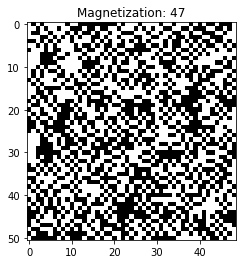

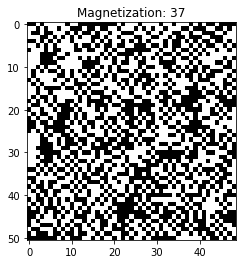

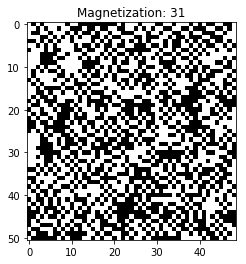

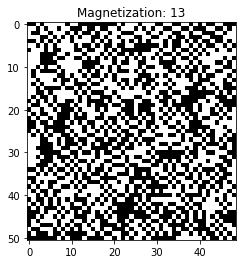

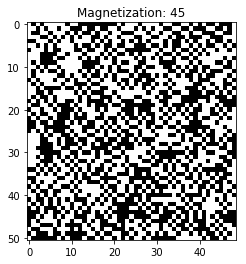

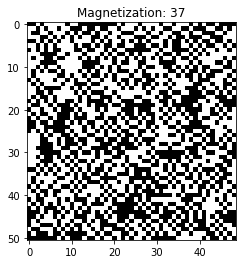

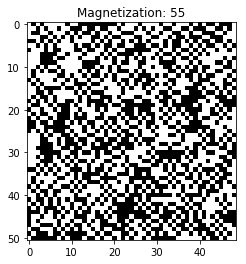

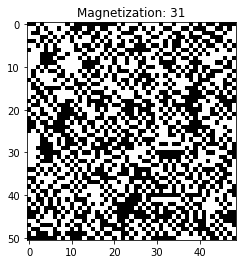

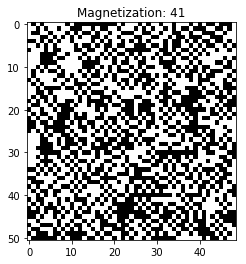

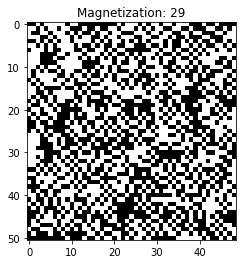

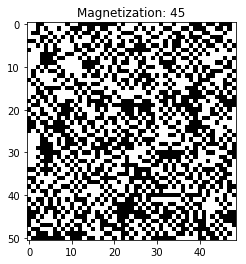

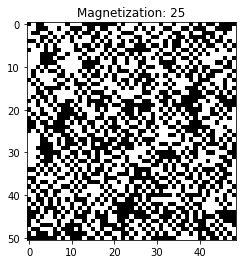

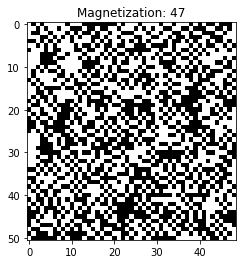

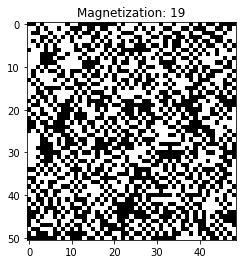

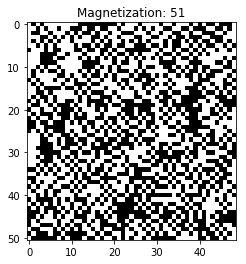

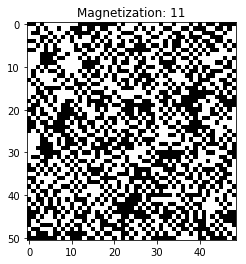

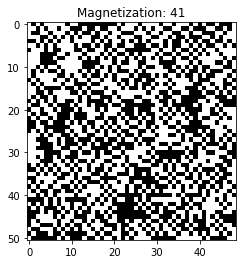

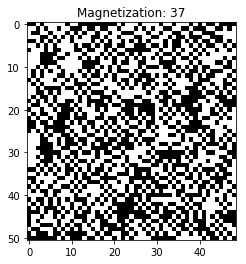

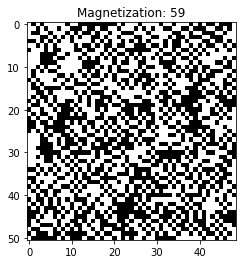

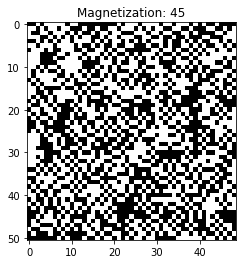

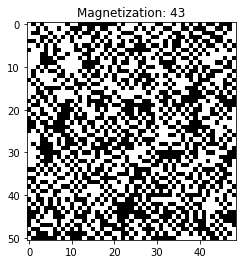

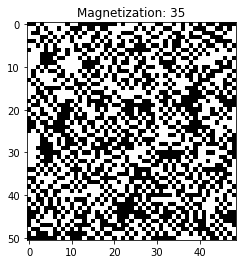

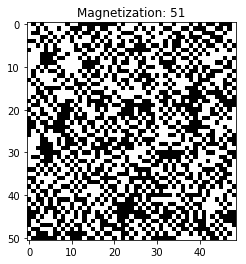

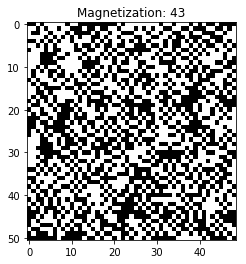

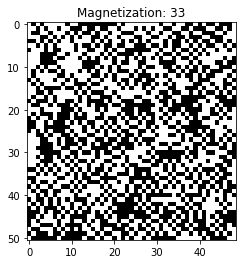

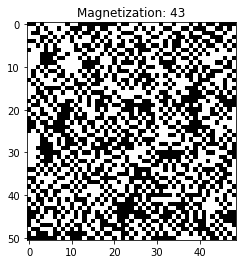

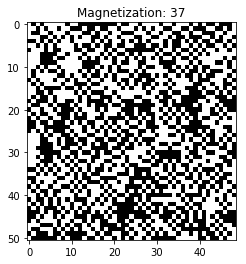

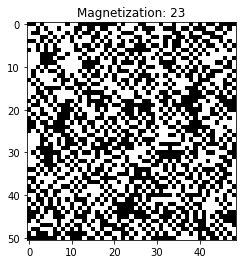

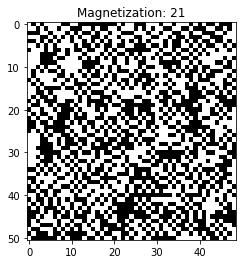

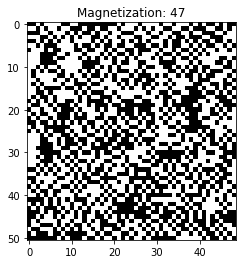

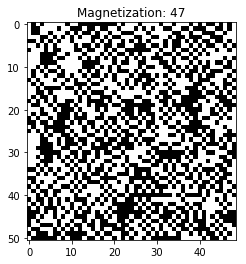

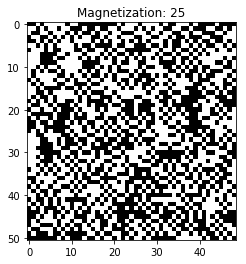

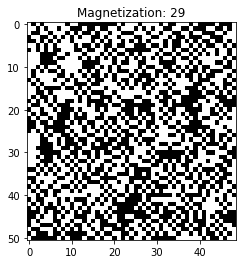

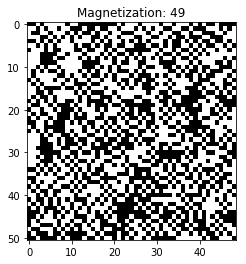

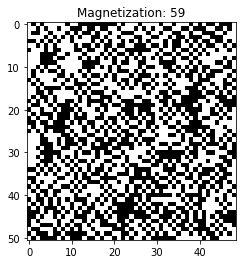

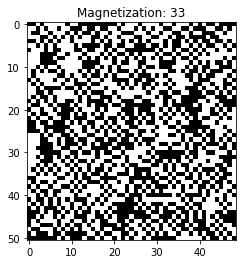

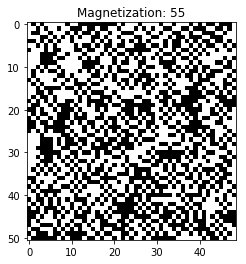

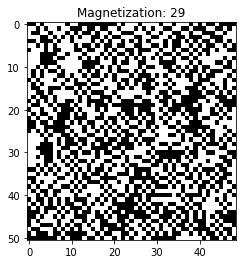

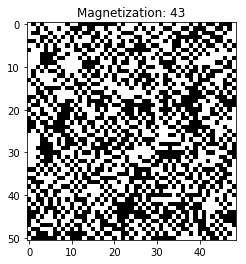

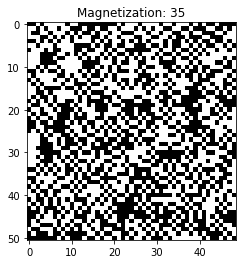

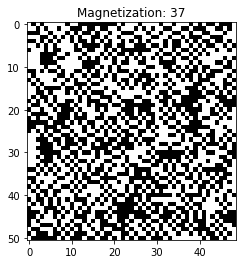

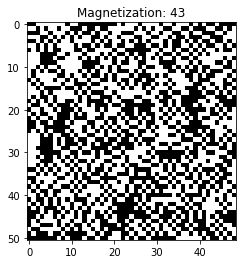

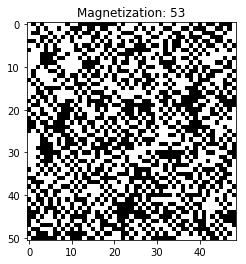

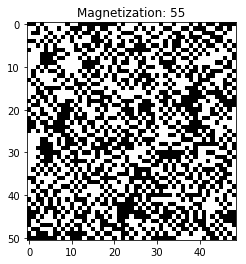

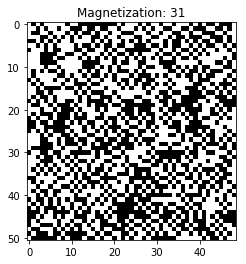

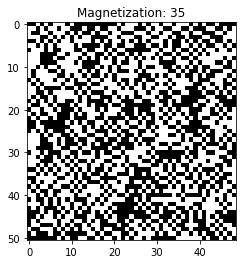

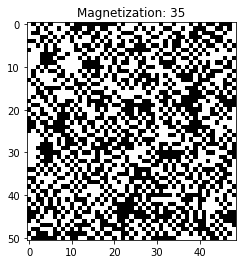

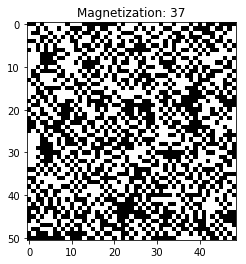

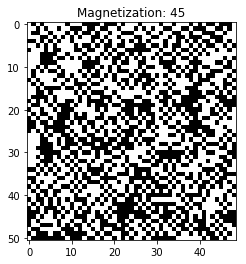

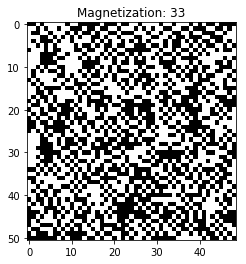

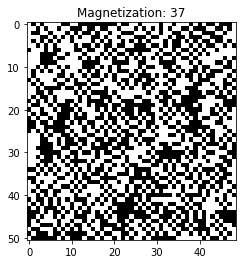

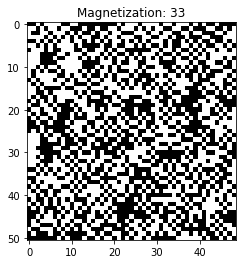

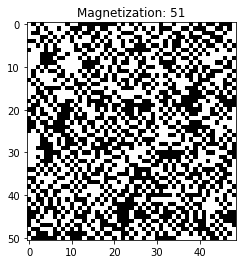

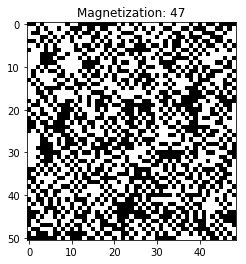

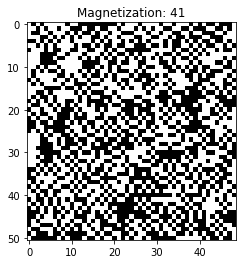

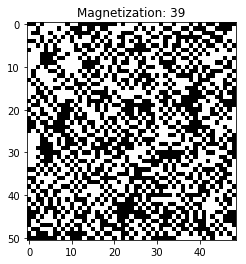

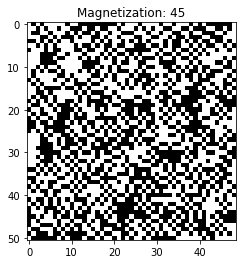

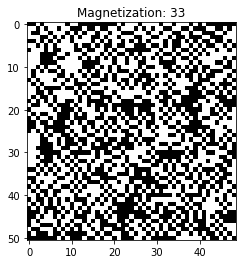

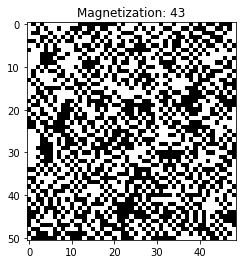

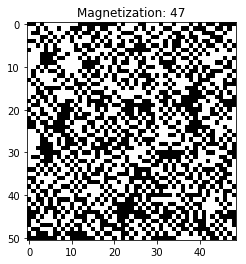

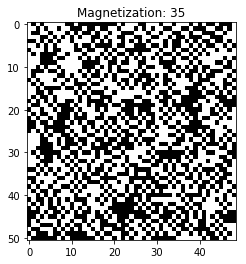

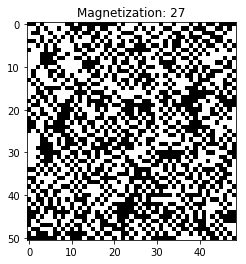

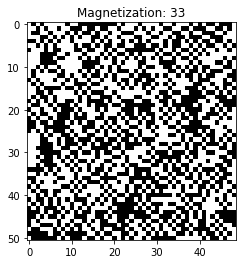

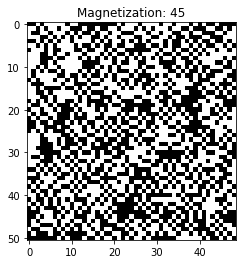

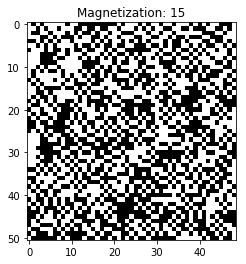

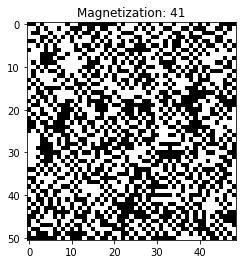

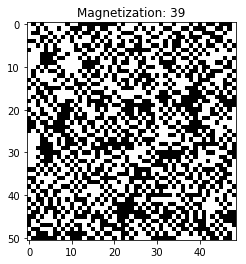

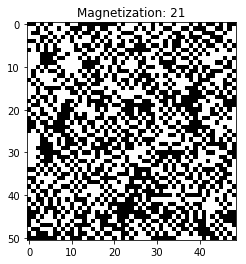

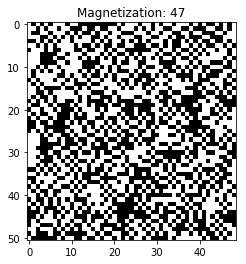

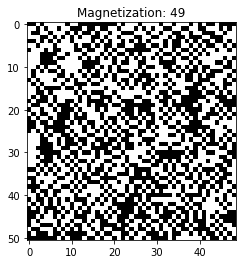

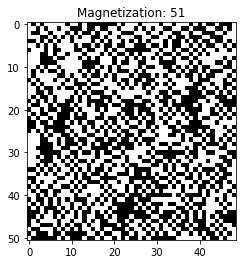

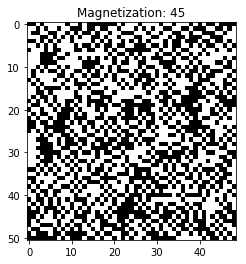

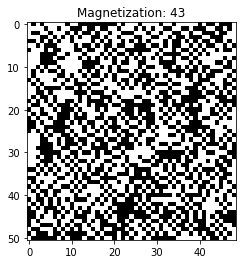

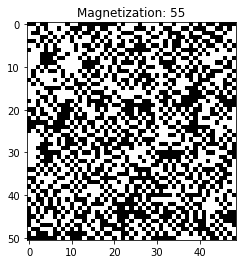

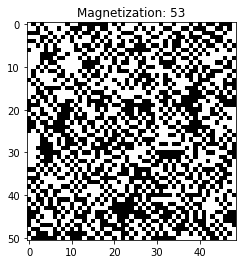

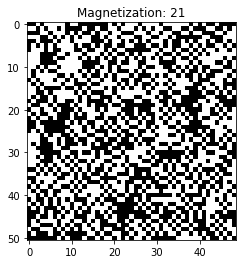

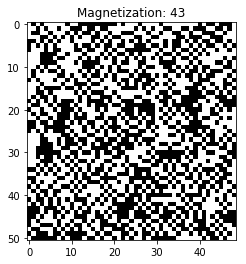

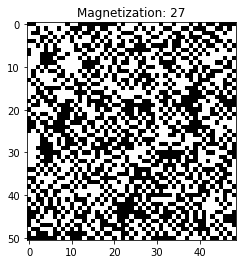

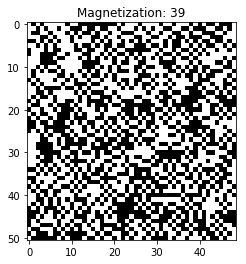

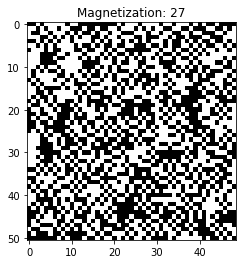

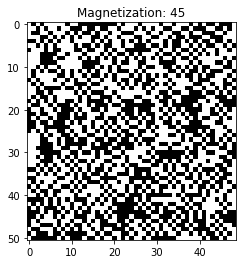

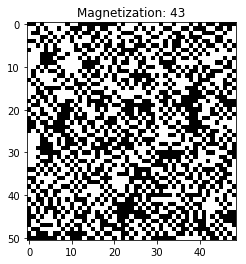

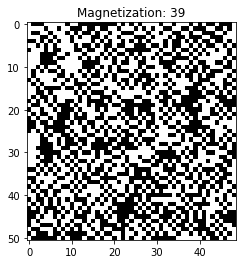

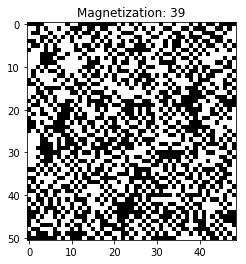

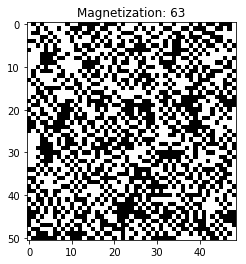

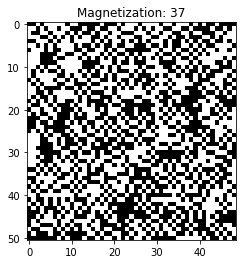

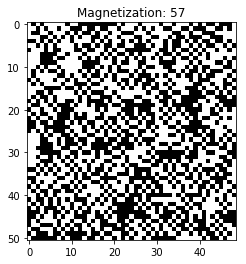

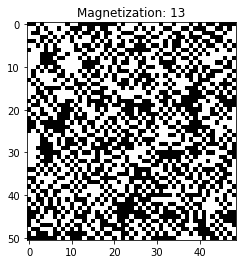

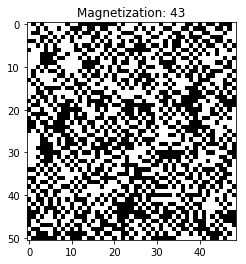

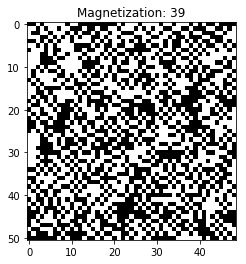

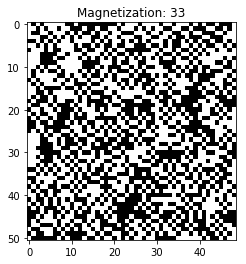

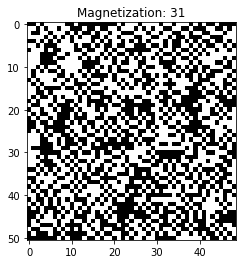

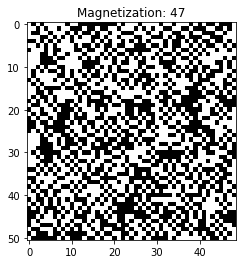

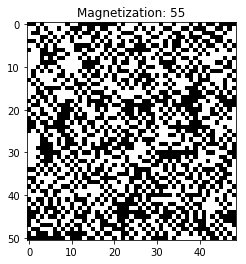

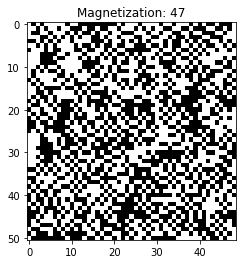

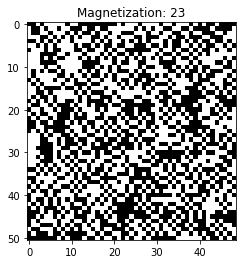

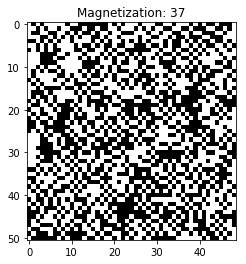

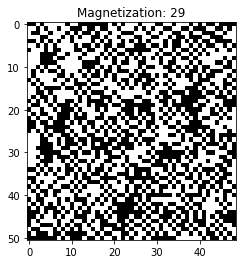

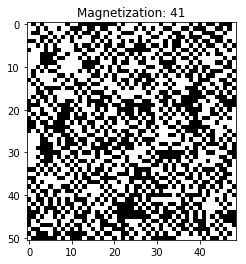

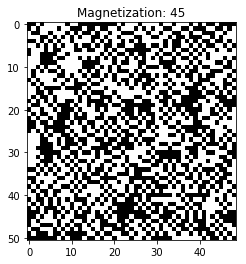

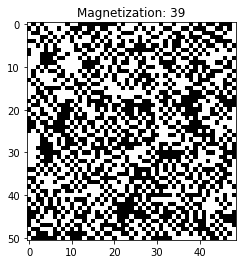

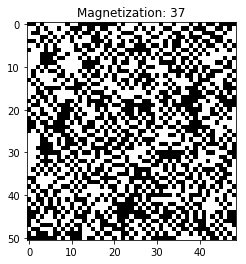

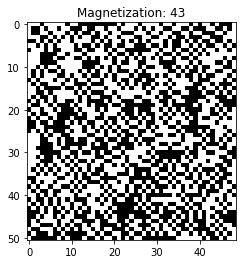

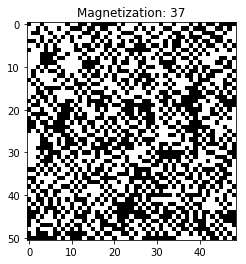

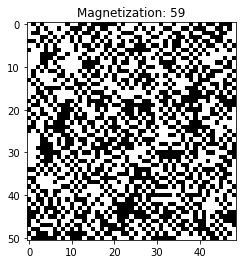

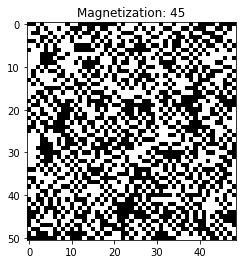

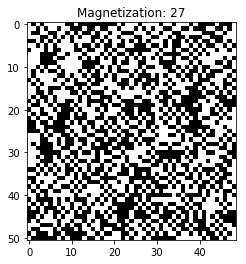

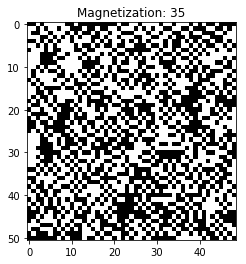

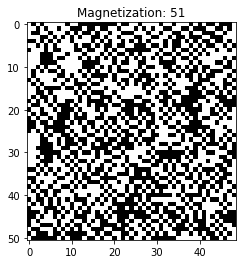

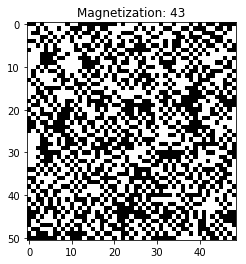

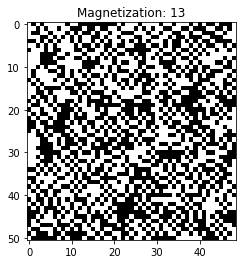

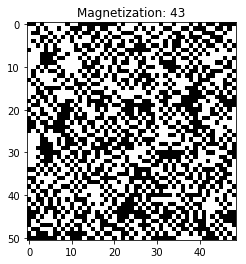

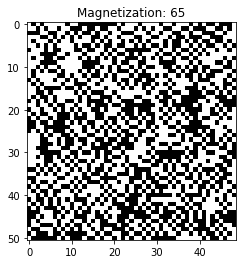

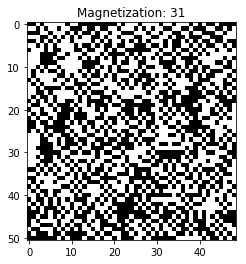

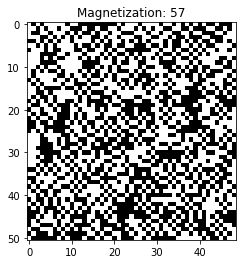

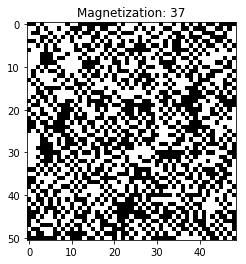

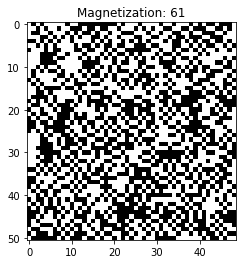

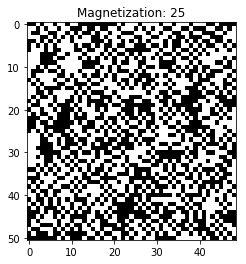

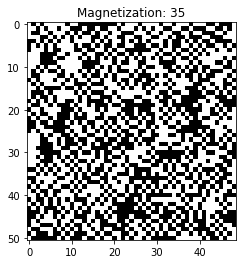

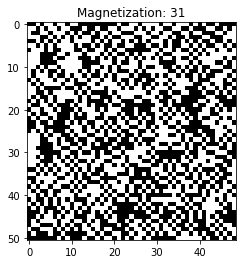

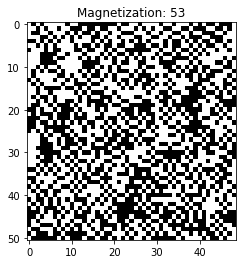

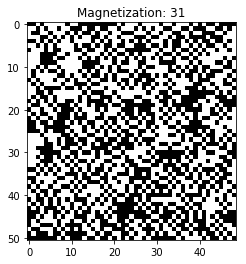

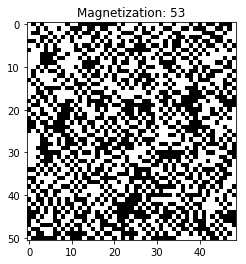

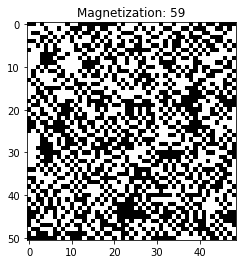

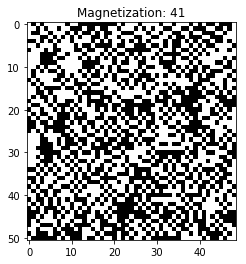

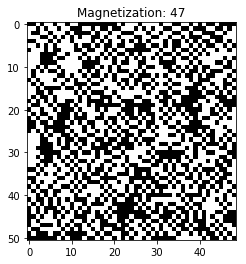

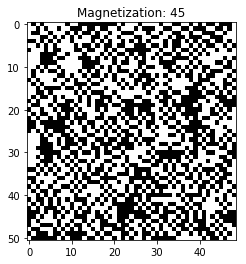

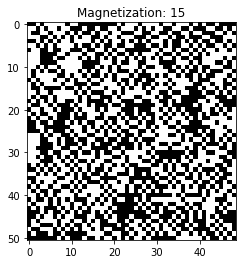

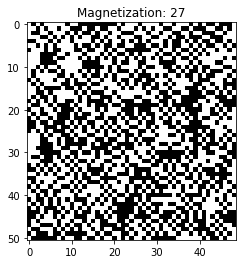

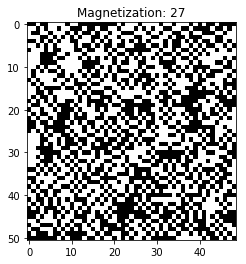

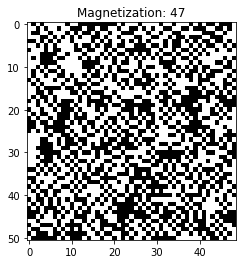

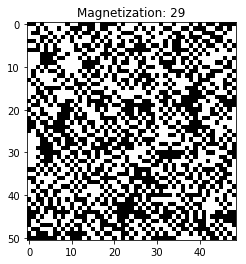

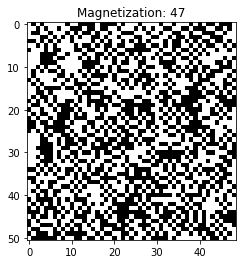

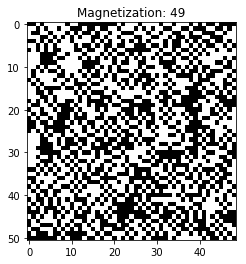

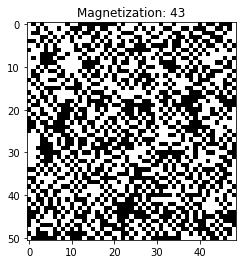

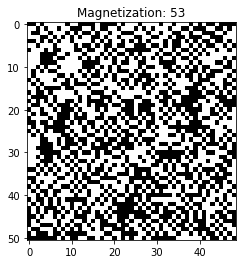

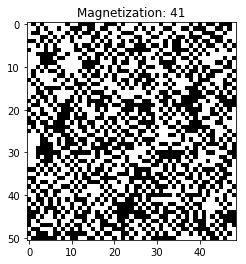

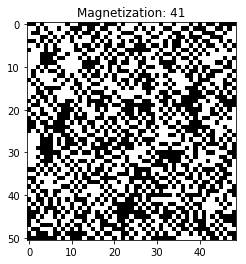

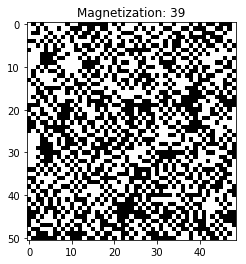

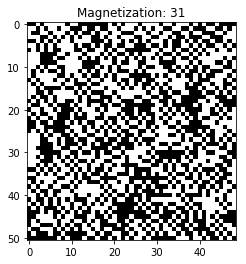

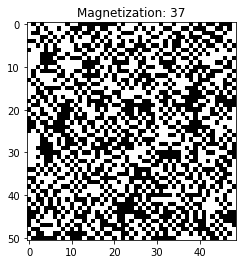

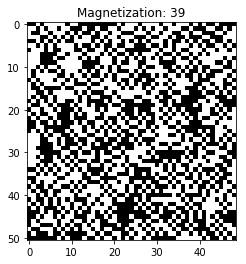

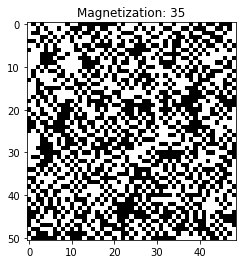

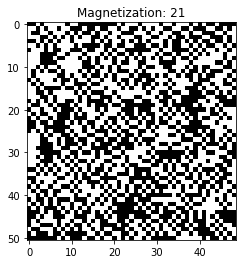

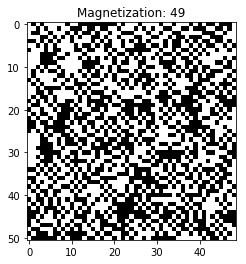

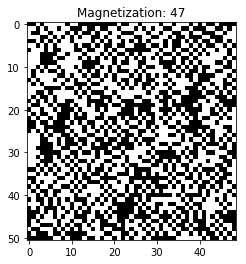

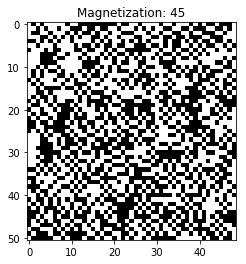

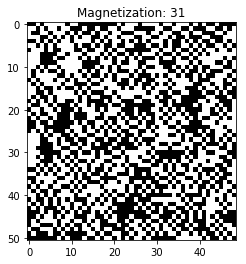

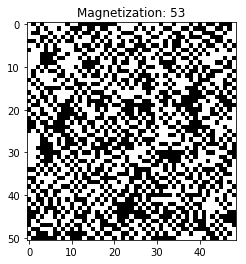

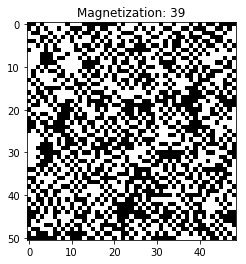

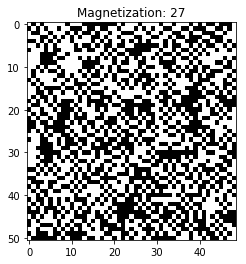

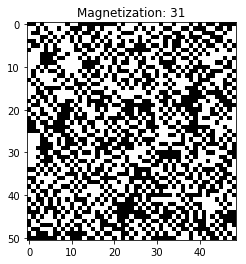

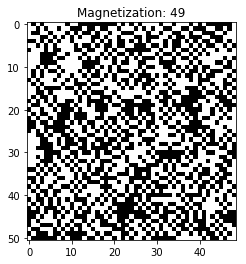

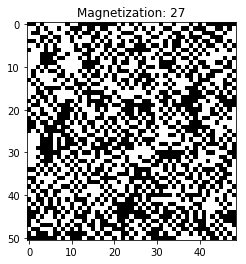

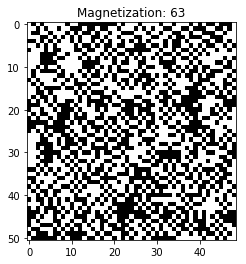

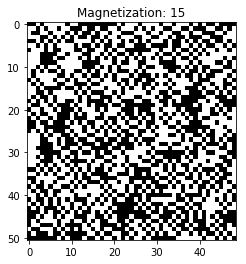

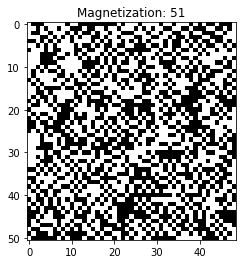

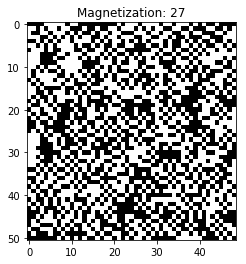

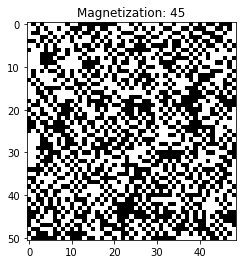

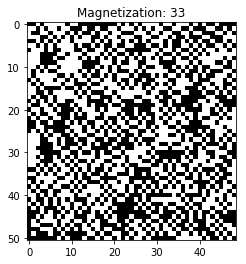

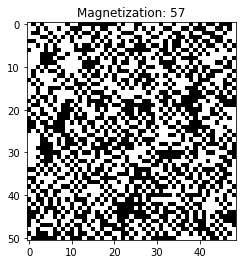

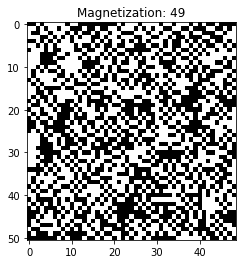

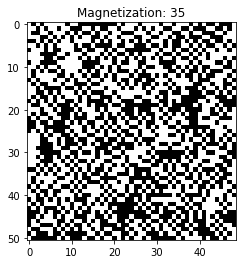

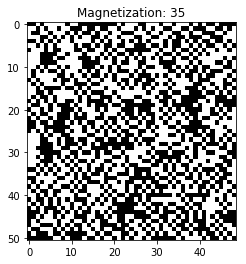

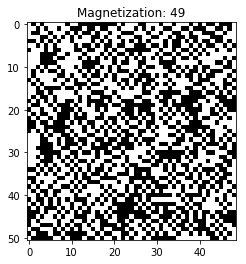

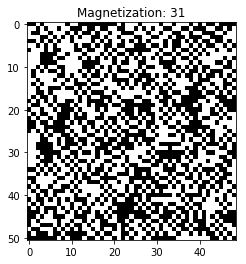

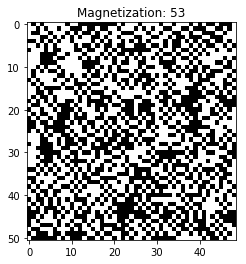

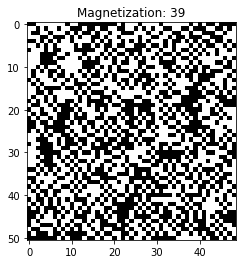

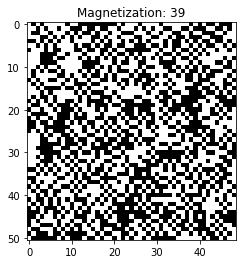

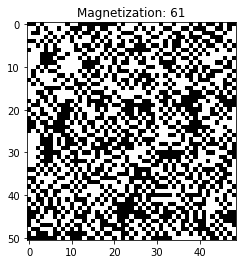

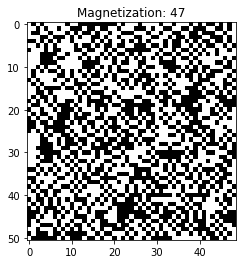

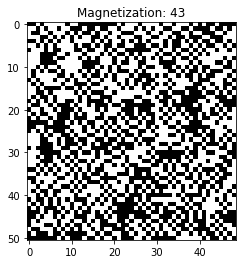

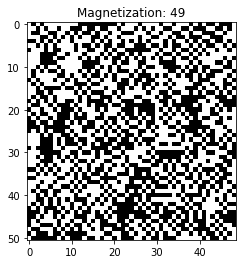

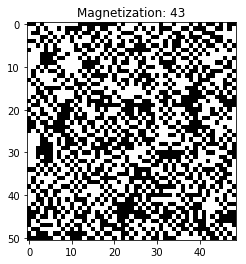

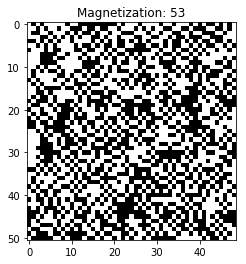

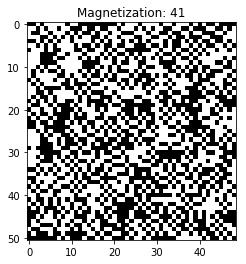

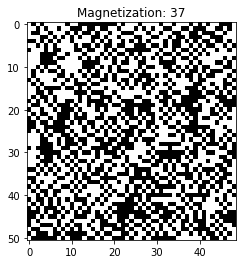

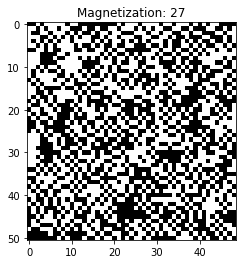

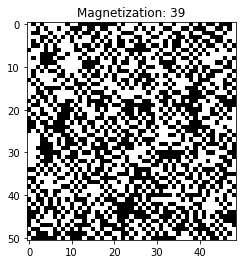

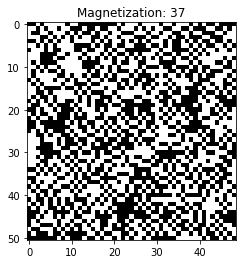

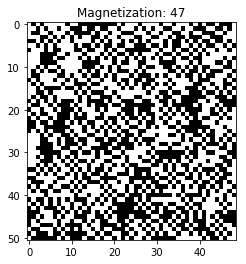

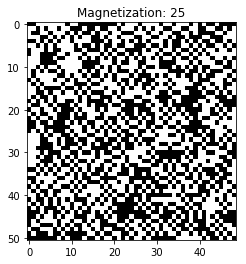

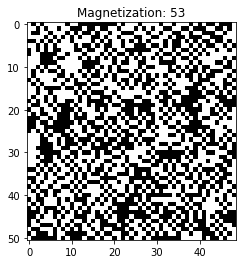

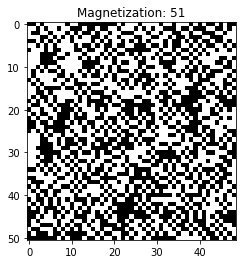

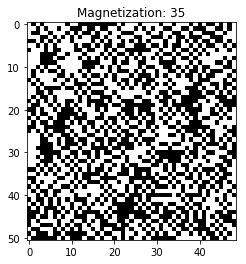

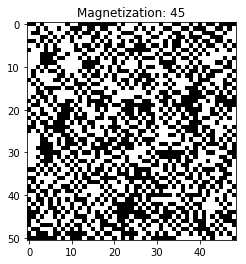

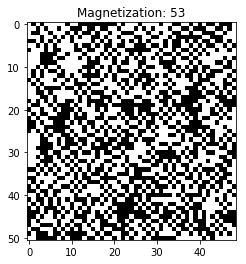

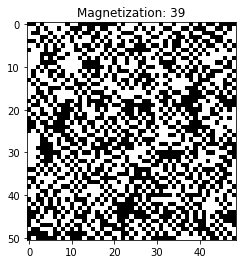

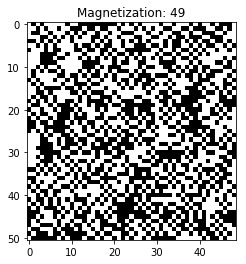

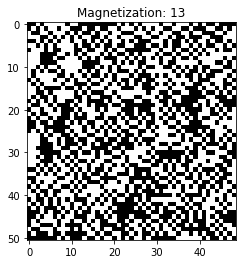

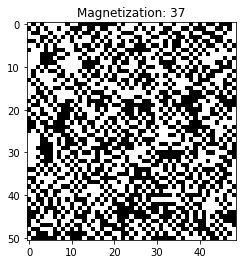

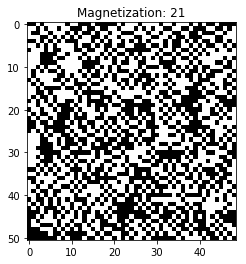

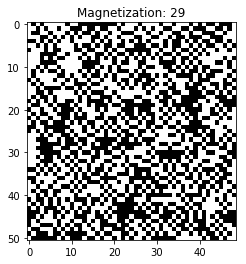

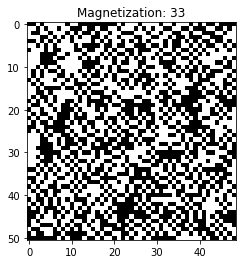

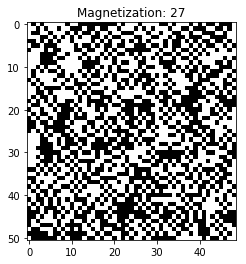

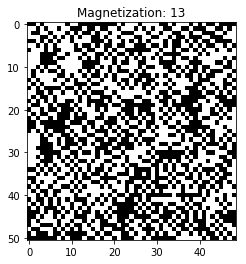

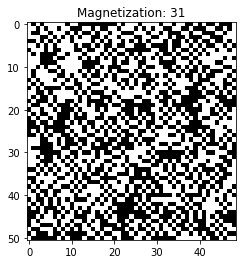

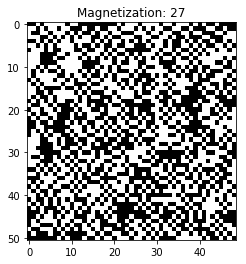

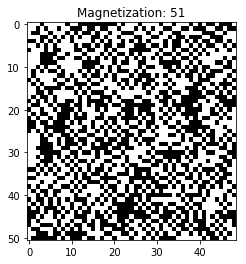

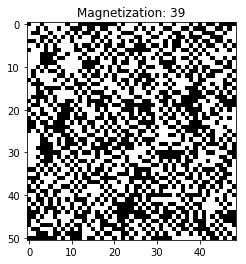

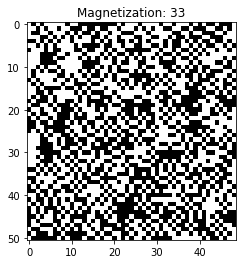

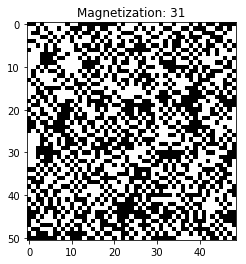

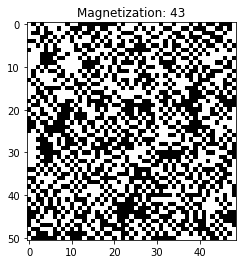

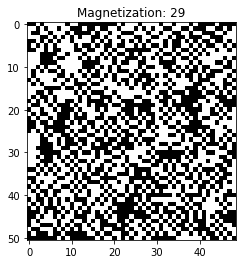

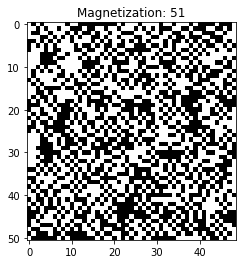

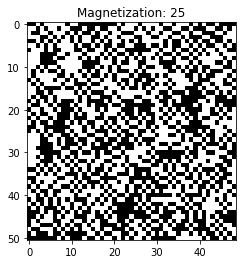

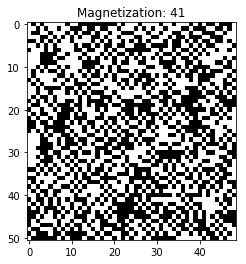

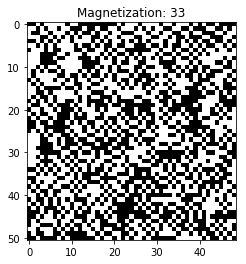

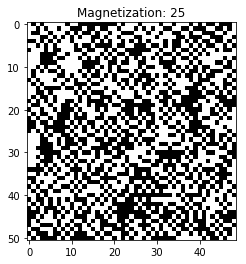

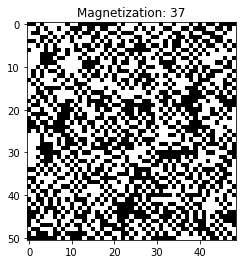

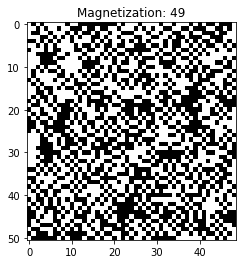

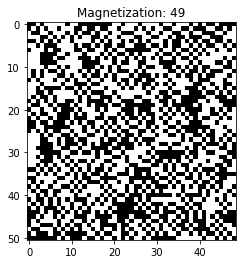

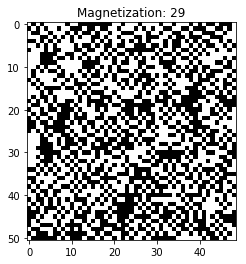

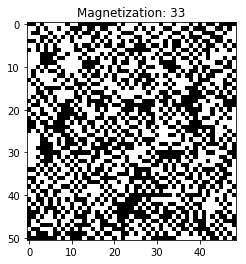

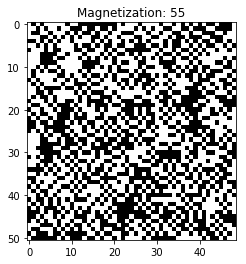

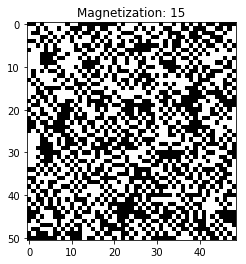

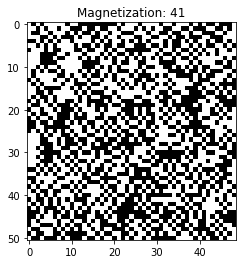

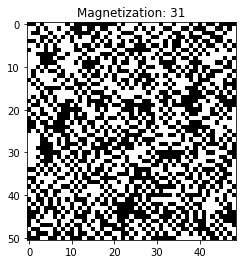

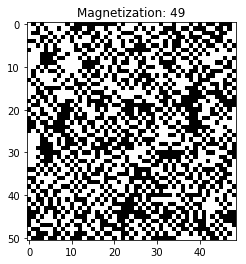

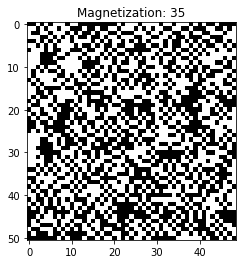

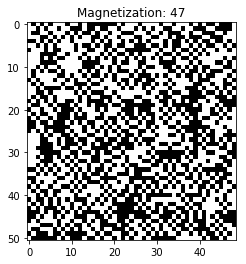

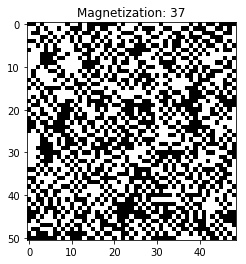

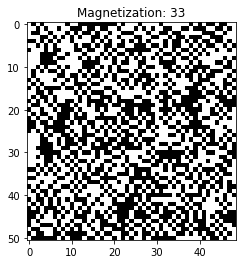

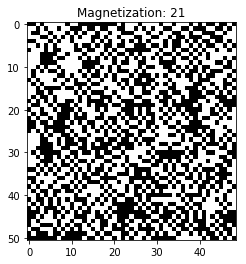

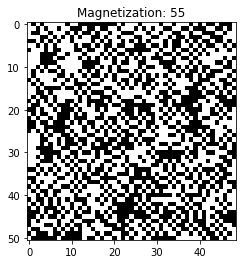

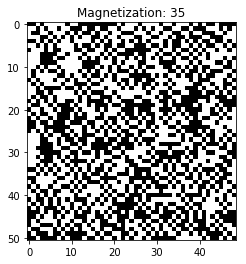

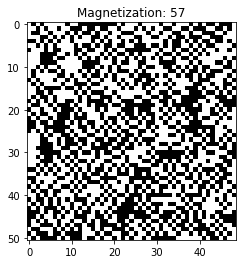

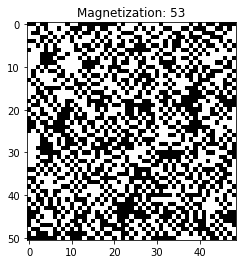

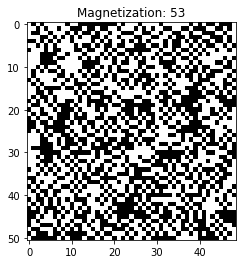

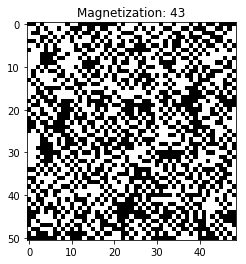

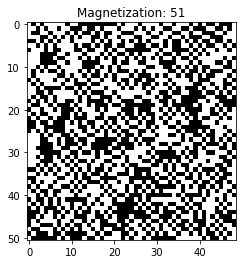

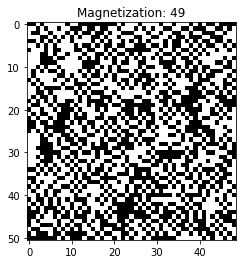

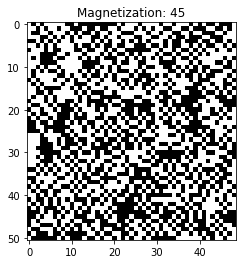

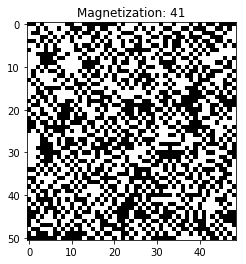

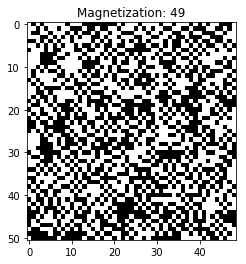

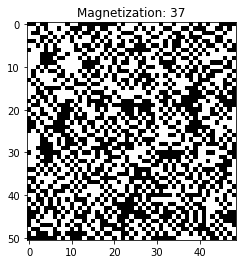

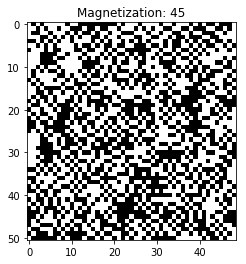

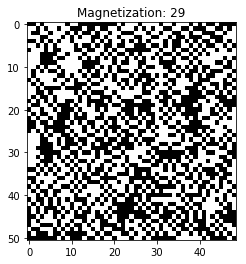

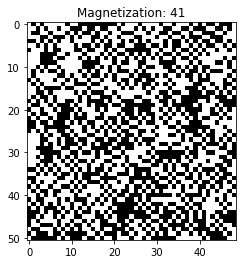

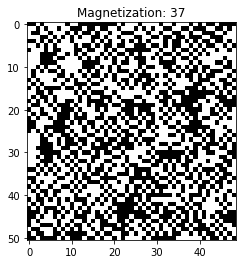

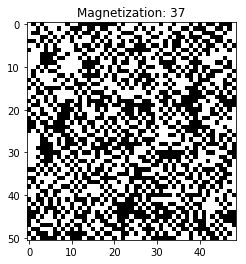

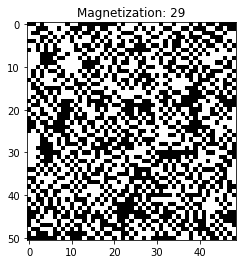

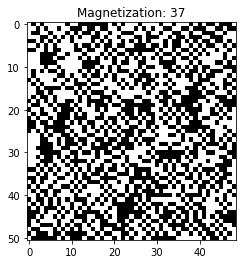

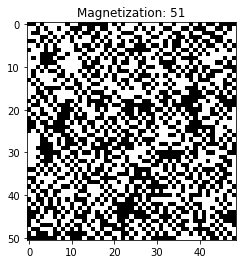

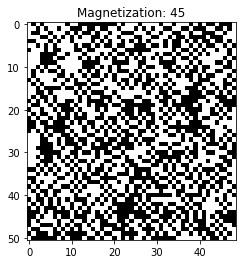

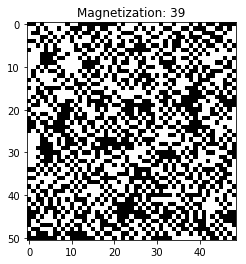

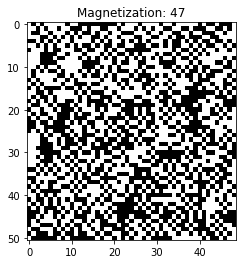

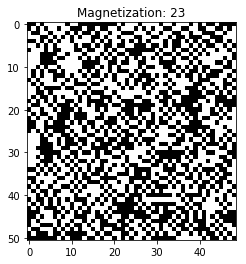

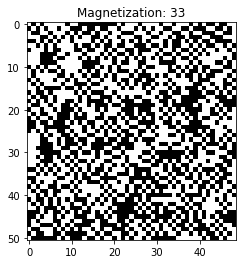

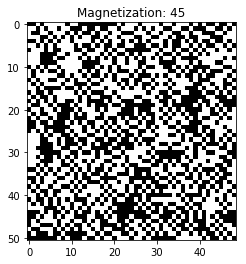

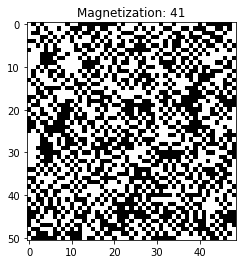

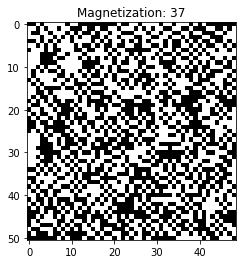

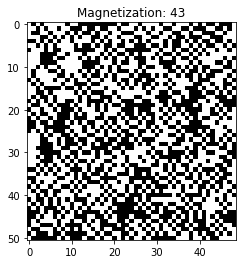

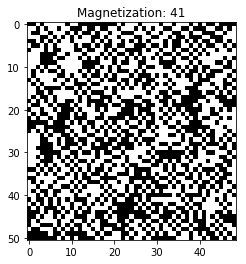

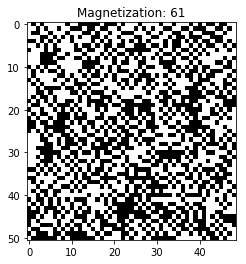

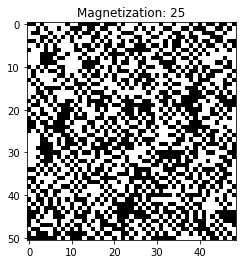

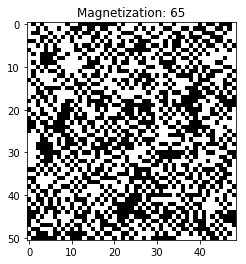

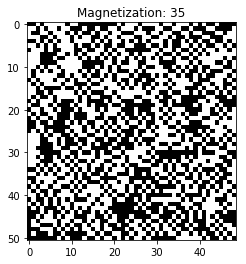

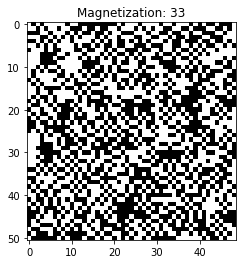

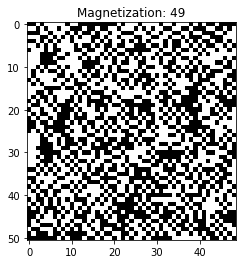

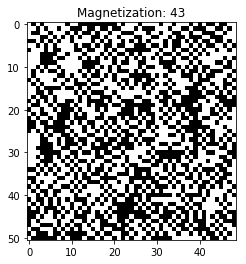

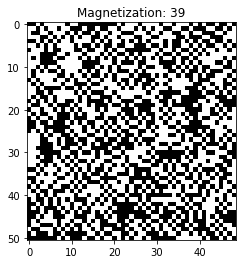

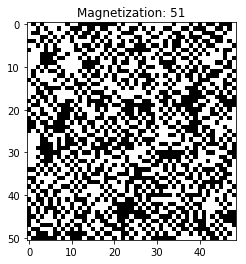

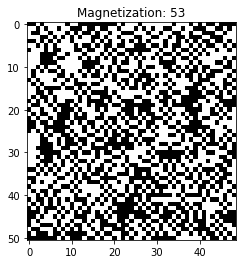

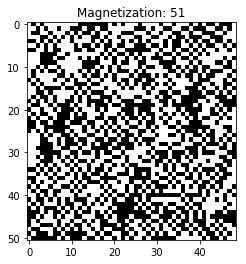

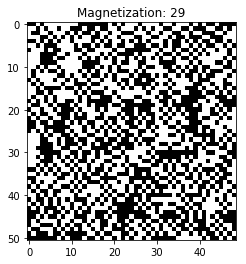

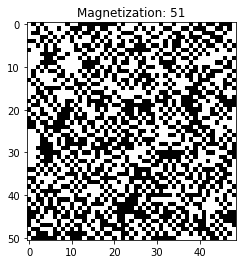

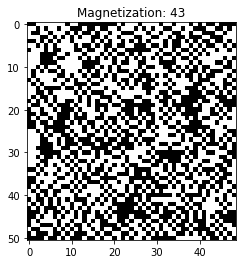

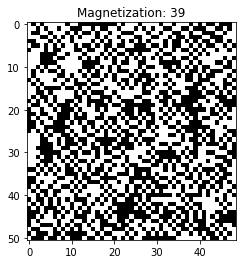

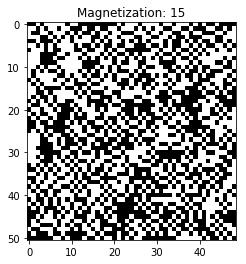

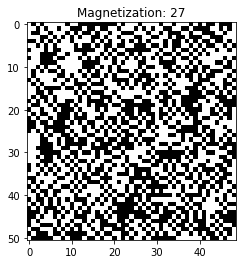

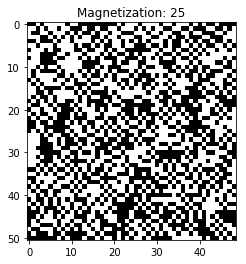

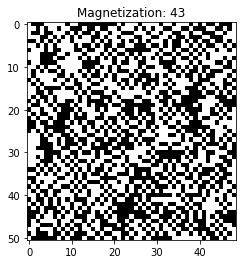

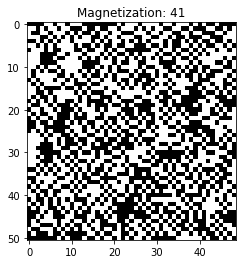

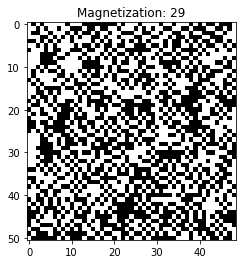

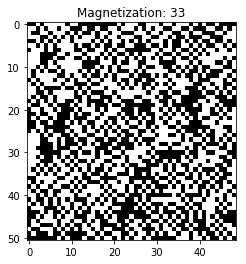

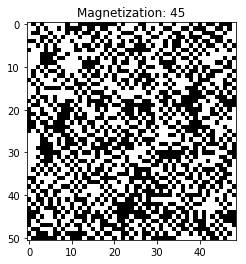

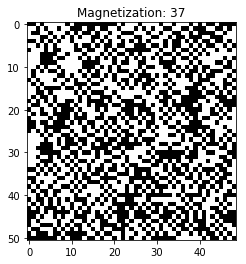

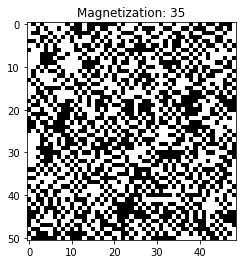

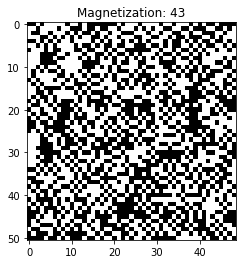

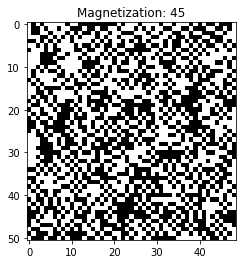

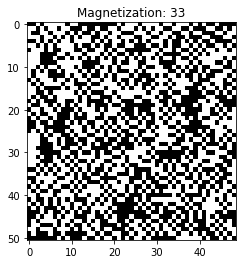

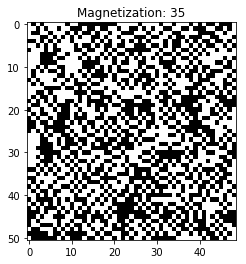

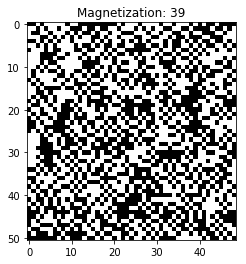

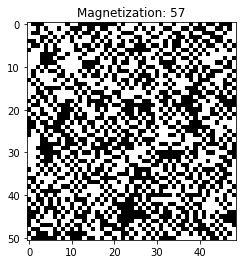

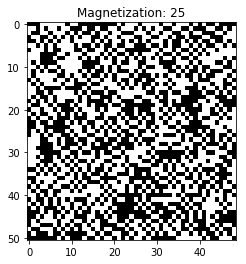

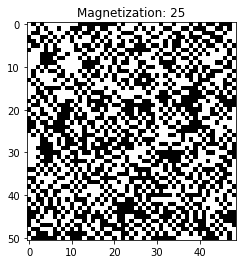

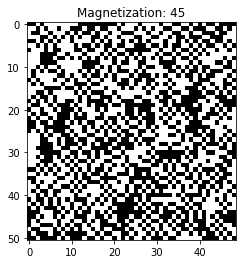

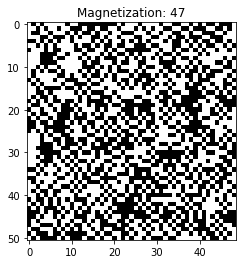

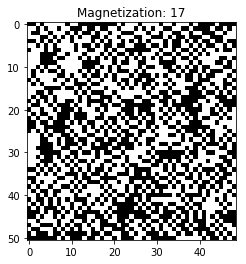

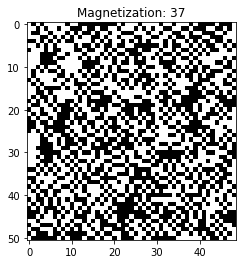

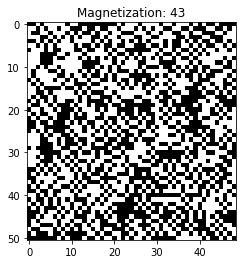

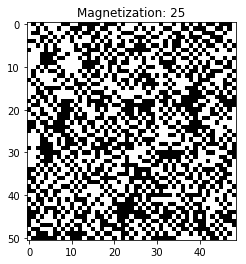

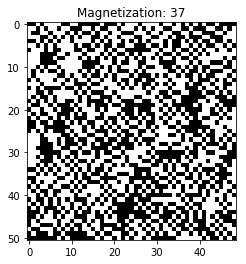

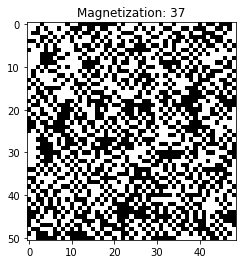

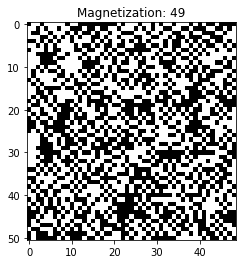

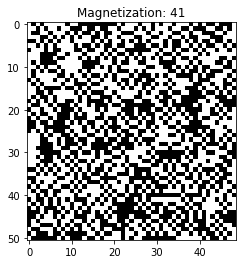

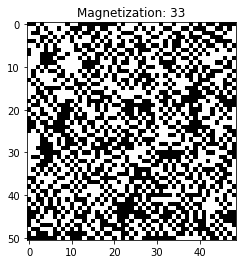

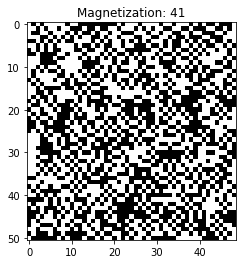

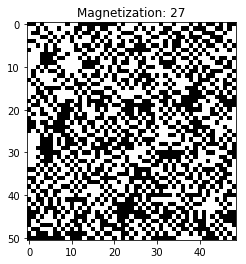

In [19]:
B=0
T=2
J=-T
mag_list=[]

state,pd_state=setup_ini_state([51,49])
for i in range(900):
    state,pd_state=Ising_evolution(state,pd_state,B,T,J)

    plt.title("Magnetization: "+str(magnetization(state)))
    plt.imshow(state,cmap='gray')
    plt.show()

    



## Bonus: property of ferromagnetic material

In [46]:
mag_list=[]
state,wrap_state=setup_ini_state([51,49])
T=3.5
J=1

B=0

for i in range(90):
    state,wrap_state=Ising_evolution(state,wrap_state,B,T,J)
    mag_list.append(magnetization(state))

B=5

for i in range(90):
    state,wrap_state=Ising_evolution(state,wrap_state,B,T,J)
    mag_list.append(magnetization(state))

B=0
for i in range(90):
    state,wrap_state=Ising_evolution(state,wrap_state,B,T,J)
    mag_list.append(magnetization(state))
    

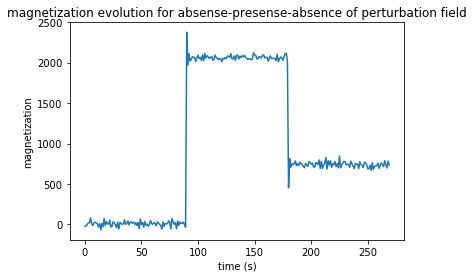

In [47]:
plt.title("magnetization evolution for absense-presense-absence of perturbation field")
plt.xlabel("time (s)")
plt.ylabel("magnetization")
plt.plot(np.arange(len(mag_list)),mag_list)
plt.show()